Import the Necessary Libraries

In [1]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam  # Import Adam optimizer
from tensorflow.keras.losses import MeanAbsoluteError
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

from tensorflow import keras
# import cv2
import tensorflow as tf
import os as os
import nibabel as nib
import pandas as pd
import numpy as np
import scipy as sci



import numpy as np
from scipy.ndimage import rotate
import random
from scipy.ndimage import gaussian_filter

from scipy.ndimage import shift
import random

from scipy.ndimage import zoom
import random


2024-02-07 00:00:57.856651: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-07 00:00:57.900839: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 00:00:57.900870: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 00:00:57.900897: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 00:00:57.908925: I tensorflow/core/platform/cpu_feature_g

In [19]:
def load_zoomeddataset():
    # Directory containing the MRI images
    image_dir = '/home/allenC/AllBrains/'
    # Directory containing the CSV files
    csv_dir = '/home/allenC/Downloads/'

    # Initialize lists to store the MRI images and ages
    zoom_factor = (0.5, 0.5, 0.5)
    X = []
    Y = []
    
    counter = 0

    # Loop through the files in the image directory
    for file in os.listdir(image_dir):
        counter+=1
        if (counter % 100 == 0):
            print(counter)
        if file.startswith('brain') and file.endswith('.mgz'):
            # Load the MRI image
            image = nib.load(os.path.join(image_dir, file)).get_fdata()
            image = np.array(image, dtype = np.int8)
            # Remove the 'brain' prefix from the filename to match with the CSV
            id = file[5:-4]
            # Apply the zoom
            X_zoomed = sci.ndimage.zoom(image, zoom=zoom_factor, order=3)
            
            # Loop through the CSV files
            for csv_file in os.listdir(csv_dir):
                if csv_file.endswith('.csv'):
                    # Load the CSV file
                    df = pd.read_csv(os.path.join(csv_dir, csv_file), header=None)
                    # Find the corresponding age in the CSV
                    if csv_file == "s3 Metadata and Subjects - HCP_Demographics.csv":
                        age = df.loc[df[0] == id, 2].values
                    elif csv_file == "CNrecons_ages.csv":
                        age = df.loc[df[0] == id, 1].values
                    if len(age) > 0 and age[0] != '#VALUE!':  # Skip if age is 'MISSING'
                        # Append the image and age to their respective lists
                        X.append(X_zoomed)
                        Y.append(np.float32(age[0]))  # Convert age to float before appending
                        break

    # Convert the lists to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    dir = "/mnt/md0/tempFolder/Allen/TrainTestData/"
    # Xtrain = "Xtrain"  # change this to your preferred filename
    # Xtest = "Xtest"
    # ytrain = "ytrain"
    # ytest = "ytest"
    # Save the array to a binary file in .npy format
    np.save(dir + "Xtrain" + '.npy', X_train)
    np.save(dir + "Xtest" + '.npy', X_test)
    np.save(dir + "ytrain" + '.npy', y_train)
    np.save(dir + "ytest" + '.npy', y_test)

    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)

    print("Average Age: ", np.mean(Y))
    print("Lowest Age: ", np.min(Y))
    print("Higest Age: ", np.max(Y))

    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = load_zoomeddataset()


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
X_train shape: (2804, 128, 128, 128)
X_test shape: (702, 128, 128, 128)
y_train shape: (2804,)
y_test shape: (702,)
Average Age:  67.29226
Lowest Age:  18.916666
Higest Age:  100.25


In [ ]:
dir = "/mnt/md0/tempFolder/Allen/TrainTestData/"
# Xtrain = "Xtrain"  # change this to your preferred filename
# Xtest = "Xtest"
# ytrain = "ytrain"
# ytest = "ytest"
# Save the array to a binary file in .npy format
np.save(dir + Xtrain + '.npy', X_train)
np.save(dir + Xtest + '.npy', X_test)
np.save(dir + ytrain + '.npy', y_train)
np.save(dir + ytest + '.npy', y_test)

In [14]:
def get_model(width=128, height=128, depth=128): 
 
    inputs = tf.keras.Input((width, height, depth, 1))
 
    x = tf.keras.layers.Conv3D(filters=16, kernel_size=5, activation="relu")(inputs)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
 
    x = tf.keras.layers.Conv3D(filters=32, kernel_size=5, activation="relu")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
 
    x = tf.keras.layers.Conv3D(filters=64, kernel_size=5, activation="relu")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Conv3D(filters=128, kernel_size=5, activation="relu")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    x = tf.keras.layers.Dense(units=128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
 
    outputs = tf.keras.layers.Dense(units=1, activation="relu")(x)
 
    # Define the model.
    model = keras.Model(inputs, outputs, name="BA-3DCNN_conv4k5d2")
    return model

Epoch 1/350
201/201 [==============================] - ETA: 0s - loss: 35.4755 - mean_absolute_error: 35.4755
Epoch 1: val_mean_absolute_error improved from inf to 13.10391, saving model to /mnt/md0/tempFolder/Allen/Models/NormalModel.h5
201/201 [==============================] - 109s 538ms/step - loss: 35.4755 - mean_absolute_error: 35.4755 - val_loss: 13.1039 - val_mean_absolute_error: 13.1039
Epoch 2/350


/mnt/md0/softwares/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


201/201 [==============================] - ETA: 0s - loss: 14.1417 - mean_absolute_error: 14.1417
Epoch 2: val_mean_absolute_error improved from 13.10391 to 10.75351, saving model to /mnt/md0/tempFolder/Allen/Models/NormalModel.h5
201/201 [==============================] - 109s 542ms/step - loss: 14.1417 - mean_absolute_error: 14.1417 - val_loss: 10.7535 - val_mean_absolute_error: 10.7535
Epoch 3/350
201/201 [==============================] - ETA: 0s - loss: 11.0612 - mean_absolute_error: 11.0612
Epoch 3: val_mean_absolute_error did not improve from 10.75351
201/201 [==============================] - 106s 529ms/step - loss: 11.0612 - mean_absolute_error: 11.0612 - val_loss: 14.6687 - val_mean_absolute_error: 14.6687
Epoch 4/350
201/201 [==============================] - ETA: 0s - loss: 10.0052 - mean_absolute_error: 10.0052
Epoch 4: val_mean_absolute_error did not improve from 10.75351
201/201 [==============================] - 103s 514ms/step - loss: 10.0052 - mean_absolute_error: 10.

Epoch 26/350
201/201 [==============================] - ETA: 0s - loss: 6.6629 - mean_absolute_error: 6.6629
Epoch 26: val_mean_absolute_error did not improve from 6.78087
201/201 [==============================] - 107s 534ms/step - loss: 6.6629 - mean_absolute_error: 6.6629 - val_loss: 10.2160 - val_mean_absolute_error: 10.2160
Epoch 27/350
201/201 [==============================] - ETA: 0s - loss: 6.6751 - mean_absolute_error: 6.6751
Epoch 27: val_mean_absolute_error did not improve from 6.78087
201/201 [==============================] - 107s 531ms/step - loss: 6.6751 - mean_absolute_error: 6.6751 - val_loss: 19.0518 - val_mean_absolute_error: 19.0518
Epoch 28/350
201/201 [==============================] - ETA: 0s - loss: 6.6966 - mean_absolute_error: 6.6966
Epoch 28: val_mean_absolute_error did not improve from 6.78087
201/201 [==============================] - 108s 538ms/step - loss: 6.6966 - mean_absolute_error: 6.6966 - val_loss: 7.5817 - val_mean_absolute_error: 7.5817
Epoch 29/

Epoch 51/350
201/201 [==============================] - ETA: 0s - loss: 5.7325 - mean_absolute_error: 5.7325
Epoch 51: val_mean_absolute_error did not improve from 6.30331
201/201 [==============================] - 105s 524ms/step - loss: 5.7325 - mean_absolute_error: 5.7325 - val_loss: 6.3704 - val_mean_absolute_error: 6.3704
Epoch 52/350
201/201 [==============================] - ETA: 0s - loss: 6.0027 - mean_absolute_error: 6.0027
Epoch 52: val_mean_absolute_error did not improve from 6.30331
201/201 [==============================] - 106s 527ms/step - loss: 6.0027 - mean_absolute_error: 6.0027 - val_loss: 7.6191 - val_mean_absolute_error: 7.6191
Epoch 53/350
201/201 [==============================] - ETA: 0s - loss: 6.1804 - mean_absolute_error: 6.1804
Epoch 53: val_mean_absolute_error did not improve from 6.30331
201/201 [==============================] - 106s 529ms/step - loss: 6.1804 - mean_absolute_error: 6.1804 - val_loss: 8.2026 - val_mean_absolute_error: 8.2026
Epoch 54/350


201/201 [==============================] - ETA: 0s - loss: 5.5051 - mean_absolute_error: 5.5051
Epoch 75: val_mean_absolute_error did not improve from 5.66082
201/201 [==============================] - 105s 525ms/step - loss: 5.5051 - mean_absolute_error: 5.5051 - val_loss: 6.8311 - val_mean_absolute_error: 6.8311
Epoch 76/350
201/201 [==============================] - ETA: 0s - loss: 5.7048 - mean_absolute_error: 5.7048
Epoch 76: val_mean_absolute_error did not improve from 5.66082
201/201 [==============================] - 105s 522ms/step - loss: 5.7048 - mean_absolute_error: 5.7048 - val_loss: 7.2857 - val_mean_absolute_error: 7.2857
Epoch 77/350
201/201 [==============================] - ETA: 0s - loss: 5.5739 - mean_absolute_error: 5.5739
Epoch 77: val_mean_absolute_error did not improve from 5.66082
201/201 [==============================] - 106s 527ms/step - loss: 5.5739 - mean_absolute_error: 5.5739 - val_loss: 6.8183 - val_mean_absolute_error: 6.8183
Epoch 78/350
201/201 [====

Epoch 100/350
201/201 [==============================] - ETA: 0s - loss: 5.4815 - mean_absolute_error: 5.4815
Epoch 100: val_mean_absolute_error did not improve from 5.28662
201/201 [==============================] - 105s 525ms/step - loss: 5.4815 - mean_absolute_error: 5.4815 - val_loss: 9.7237 - val_mean_absolute_error: 9.7237
Epoch 101/350
201/201 [==============================] - ETA: 0s - loss: 5.3852 - mean_absolute_error: 5.3852
Epoch 101: val_mean_absolute_error did not improve from 5.28662
201/201 [==============================] - 105s 521ms/step - loss: 5.3852 - mean_absolute_error: 5.3852 - val_loss: 5.5160 - val_mean_absolute_error: 5.5160
Epoch 102/350
201/201 [==============================] - ETA: 0s - loss: 5.4129 - mean_absolute_error: 5.4129
Epoch 102: val_mean_absolute_error did not improve from 5.28662
201/201 [==============================] - 105s 522ms/step - loss: 5.4129 - mean_absolute_error: 5.4129 - val_loss: 5.8499 - val_mean_absolute_error: 5.8499
Epoch 1

Epoch 125/350
201/201 [==============================] - ETA: 0s - loss: 5.3083 - mean_absolute_error: 5.3083
Epoch 125: val_mean_absolute_error did not improve from 5.05599
201/201 [==============================] - 104s 519ms/step - loss: 5.3083 - mean_absolute_error: 5.3083 - val_loss: 5.4400 - val_mean_absolute_error: 5.4400
Epoch 126/350
201/201 [==============================] - ETA: 0s - loss: 5.2787 - mean_absolute_error: 5.2787
Epoch 126: val_mean_absolute_error did not improve from 5.05599
201/201 [==============================] - 105s 523ms/step - loss: 5.2787 - mean_absolute_error: 5.2787 - val_loss: 5.3698 - val_mean_absolute_error: 5.3698
Epoch 127/350
201/201 [==============================] - ETA: 0s - loss: 5.1744 - mean_absolute_error: 5.1744
Epoch 127: val_mean_absolute_error did not improve from 5.05599
201/201 [==============================] - 105s 521ms/step - loss: 5.1744 - mean_absolute_error: 5.1744 - val_loss: 7.3219 - val_mean_absolute_error: 7.3219
Epoch 1

Epoch 150/350
201/201 [==============================] - ETA: 0s - loss: 5.1880 - mean_absolute_error: 5.1880
Epoch 150: val_mean_absolute_error did not improve from 5.05599
201/201 [==============================] - 108s 536ms/step - loss: 5.1880 - mean_absolute_error: 5.1880 - val_loss: 6.8805 - val_mean_absolute_error: 6.8805
Epoch 151/350
201/201 [==============================] - ETA: 0s - loss: 5.1530 - mean_absolute_error: 5.1530
Epoch 151: val_mean_absolute_error did not improve from 5.05599
201/201 [==============================] - 109s 544ms/step - loss: 5.1530 - mean_absolute_error: 5.1530 - val_loss: 5.3817 - val_mean_absolute_error: 5.3817
Epoch 152/350
201/201 [==============================] - ETA: 0s - loss: 5.3989 - mean_absolute_error: 5.3989
Epoch 152: val_mean_absolute_error did not improve from 5.05599
201/201 [==============================] - 107s 534ms/step - loss: 5.3989 - mean_absolute_error: 5.3989 - val_loss: 9.3007 - val_mean_absolute_error: 9.3007
Epoch 1

Epoch 175/350
201/201 [==============================] - ETA: 0s - loss: 5.2692 - mean_absolute_error: 5.2692
Epoch 175: val_mean_absolute_error did not improve from 5.05599
201/201 [==============================] - 106s 529ms/step - loss: 5.2692 - mean_absolute_error: 5.2692 - val_loss: 5.0621 - val_mean_absolute_error: 5.0621
Epoch 176/350
201/201 [==============================] - ETA: 0s - loss: 5.2655 - mean_absolute_error: 5.2655
Epoch 176: val_mean_absolute_error did not improve from 5.05599
201/201 [==============================] - 106s 527ms/step - loss: 5.2655 - mean_absolute_error: 5.2655 - val_loss: 8.2629 - val_mean_absolute_error: 8.2629
Epoch 177/350
201/201 [==============================] - ETA: 0s - loss: 5.0855 - mean_absolute_error: 5.0855
Epoch 177: val_mean_absolute_error did not improve from 5.05599
201/201 [==============================] - 106s 529ms/step - loss: 5.0855 - mean_absolute_error: 5.0855 - val_loss: 6.0434 - val_mean_absolute_error: 6.0434
Epoch 1

Epoch 224/350
201/201 [==============================] - ETA: 0s - loss: 5.0648 - mean_absolute_error: 5.0648
Epoch 224: val_mean_absolute_error did not improve from 4.89987
201/201 [==============================] - 108s 536ms/step - loss: 5.0648 - mean_absolute_error: 5.0648 - val_loss: 5.6935 - val_mean_absolute_error: 5.6935
Epoch 225/350
201/201 [==============================] - ETA: 0s - loss: 4.9977 - mean_absolute_error: 4.9977
Epoch 225: val_mean_absolute_error did not improve from 4.89987
201/201 [==============================] - 107s 532ms/step - loss: 4.9977 - mean_absolute_error: 4.9977 - val_loss: 6.4847 - val_mean_absolute_error: 6.4847
Epoch 226/350
201/201 [==============================] - ETA: 0s - loss: 5.0312 - mean_absolute_error: 5.0312
Epoch 226: val_mean_absolute_error did not improve from 4.89987
201/201 [==============================] - 107s 531ms/step - loss: 5.0312 - mean_absolute_error: 5.0312 - val_loss: 6.2932 - val_mean_absolute_error: 6.2932
Epoch 2

Epoch 249/350
201/201 [==============================] - ETA: 0s - loss: 4.9058 - mean_absolute_error: 4.9058
Epoch 249: val_mean_absolute_error did not improve from 4.89987
201/201 [==============================] - 105s 523ms/step - loss: 4.9058 - mean_absolute_error: 4.9058 - val_loss: 5.1506 - val_mean_absolute_error: 5.1506
Epoch 250/350
201/201 [==============================] - ETA: 0s - loss: 5.0566 - mean_absolute_error: 5.0566
Epoch 250: val_mean_absolute_error did not improve from 4.89987
201/201 [==============================] - 106s 529ms/step - loss: 5.0566 - mean_absolute_error: 5.0566 - val_loss: 7.3202 - val_mean_absolute_error: 7.3202
Epoch 251/350
201/201 [==============================] - ETA: 0s - loss: 4.9066 - mean_absolute_error: 4.9066
Epoch 251: val_mean_absolute_error did not improve from 4.89987
201/201 [==============================] - 106s 528ms/step - loss: 4.9066 - mean_absolute_error: 4.9066 - val_loss: 8.7806 - val_mean_absolute_error: 8.7806
Epoch 2

Epoch 274/350
201/201 [==============================] - ETA: 0s - loss: 4.9395 - mean_absolute_error: 4.9395
Epoch 274: val_mean_absolute_error did not improve from 4.89987
201/201 [==============================] - 107s 531ms/step - loss: 4.9395 - mean_absolute_error: 4.9395 - val_loss: 5.6575 - val_mean_absolute_error: 5.6575
Epoch 275/350
201/201 [==============================] - ETA: 0s - loss: 4.9060 - mean_absolute_error: 4.9060
Epoch 275: val_mean_absolute_error did not improve from 4.89987
201/201 [==============================] - 107s 532ms/step - loss: 4.9060 - mean_absolute_error: 4.9060 - val_loss: 6.1448 - val_mean_absolute_error: 6.1448
Epoch 276/350
201/201 [==============================] - ETA: 0s - loss: 5.0061 - mean_absolute_error: 5.0061
Epoch 276: val_mean_absolute_error did not improve from 4.89987
201/201 [==============================] - 107s 532ms/step - loss: 5.0061 - mean_absolute_error: 5.0061 - val_loss: 15.8732 - val_mean_absolute_error: 15.8732
Epoch

Epoch 299/350
201/201 [==============================] - ETA: 0s - loss: 4.8844 - mean_absolute_error: 4.8844
Epoch 299: val_mean_absolute_error did not improve from 4.89987
201/201 [==============================] - 105s 523ms/step - loss: 4.8844 - mean_absolute_error: 4.8844 - val_loss: 6.0616 - val_mean_absolute_error: 6.0616
Epoch 300/350
201/201 [==============================] - ETA: 0s - loss: 4.9033 - mean_absolute_error: 4.9033
Epoch 300: val_mean_absolute_error did not improve from 4.89987
201/201 [==============================] - 105s 522ms/step - loss: 4.9033 - mean_absolute_error: 4.9033 - val_loss: 5.0850 - val_mean_absolute_error: 5.0850
Epoch 301/350
201/201 [==============================] - ETA: 0s - loss: 4.8421 - mean_absolute_error: 4.8421
Epoch 301: val_mean_absolute_error did not improve from 4.89987
201/201 [==============================] - 105s 521ms/step - loss: 4.8421 - mean_absolute_error: 4.8421 - val_loss: 5.8814 - val_mean_absolute_error: 5.8814
Epoch 3

Epoch 324/350
201/201 [==============================] - ETA: 0s - loss: 4.8003 - mean_absolute_error: 4.8003
Epoch 324: val_mean_absolute_error did not improve from 4.89759
201/201 [==============================] - 105s 523ms/step - loss: 4.8003 - mean_absolute_error: 4.8003 - val_loss: 5.1763 - val_mean_absolute_error: 5.1763
Epoch 325/350
201/201 [==============================] - ETA: 0s - loss: 4.7673 - mean_absolute_error: 4.7673
Epoch 325: val_mean_absolute_error did not improve from 4.89759
201/201 [==============================] - 105s 525ms/step - loss: 4.7673 - mean_absolute_error: 4.7673 - val_loss: 5.0541 - val_mean_absolute_error: 5.0541
Epoch 326/350
201/201 [==============================] - ETA: 0s - loss: 4.8219 - mean_absolute_error: 4.8219
Epoch 326: val_mean_absolute_error did not improve from 4.89759
201/201 [==============================] - 107s 531ms/step - loss: 4.8219 - mean_absolute_error: 4.8219 - val_loss: 5.5033 - val_mean_absolute_error: 5.5033
Epoch 3

Epoch 349/350
201/201 [==============================] - ETA: 0s - loss: 4.7807 - mean_absolute_error: 4.7807
Epoch 349: val_mean_absolute_error did not improve from 4.89759
201/201 [==============================] - 106s 527ms/step - loss: 4.7807 - mean_absolute_error: 4.7807 - val_loss: 5.3758 - val_mean_absolute_error: 5.3758
Epoch 350/350
201/201 [==============================] - ETA: 0s - loss: 4.7802 - mean_absolute_error: 4.7802
Epoch 350: val_mean_absolute_error did not improve from 4.89759
201/201 [==============================] - 105s 525ms/step - loss: 4.7802 - mean_absolute_error: 4.7802 - val_loss: 8.6902 - val_mean_absolute_error: 8.6902


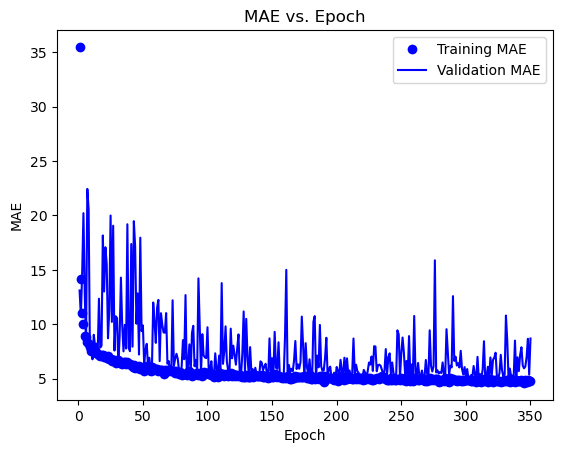

22/22 [==============================] - 6s 281ms/step
8.690238


In [16]:
def make_model():
    model = get_model()
    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=['mean_absolute_error'])

    csv_logger = CSVLogger('/mnt/md0/tempFolder/Allen/Models/Normal_log.csv')

    checkpoint = ModelCheckpoint('/mnt/md0/tempFolder/Allen/Models/NormalModel.h5', monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')
    history = model.fit(X_train, y_train, epochs=350, callbacks=[checkpoint, csv_logger], batch_size=14, validation_data=(X_test, y_test), verbose=1)

    # Get MAE values from training history
    train_mae = history.history['mean_absolute_error']
    val_mae = history.history['val_mean_absolute_error']
    epochs = range(1, len(train_mae) + 1)

    plt.figure()
    plt.plot(epochs, train_mae, 'bo', label='Training MAE')
    plt.plot(epochs, val_mae, 'b', label='Validation MAE')
    plt.title('MAE vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

    predictions = model.predict(X_test)

    mae = mean_absolute_error(y_test, predictions)
    print(mae)

    return history

model = make_model()


Epoch 1/350
401/401 [==============================] - ETA: 0s - loss: 21.3698 - mean_absolute_error: 21.3698
Epoch 1: val_mean_absolute_error improved from inf to 28.90097, saving model to /mnt/md0/tempFolder/Allen/Models/DoubleModel.h5
401/401 [==============================] - 207s 512ms/step - loss: 21.3698 - mean_absolute_error: 21.3698 - val_loss: 28.9010 - val_mean_absolute_error: 28.9010
Epoch 2/350


/mnt/md0/softwares/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


401/401 [==============================] - ETA: 0s - loss: 10.2384 - mean_absolute_error: 10.2384
Epoch 2: val_mean_absolute_error improved from 28.90097 to 25.79054, saving model to /mnt/md0/tempFolder/Allen/Models/DoubleModel.h5
401/401 [==============================] - 202s 505ms/step - loss: 10.2384 - mean_absolute_error: 10.2384 - val_loss: 25.7905 - val_mean_absolute_error: 25.7905
Epoch 3/350
401/401 [==============================] - ETA: 0s - loss: 8.4529 - mean_absolute_error: 8.4529
Epoch 3: val_mean_absolute_error improved from 25.79054 to 13.98563, saving model to /mnt/md0/tempFolder/Allen/Models/DoubleModel.h5
401/401 [==============================] - 201s 501ms/step - loss: 8.4529 - mean_absolute_error: 8.4529 - val_loss: 13.9856 - val_mean_absolute_error: 13.9856
Epoch 4/350
401/401 [==============================] - ETA: 0s - loss: 8.0929 - mean_absolute_error: 8.0929
Epoch 4: val_mean_absolute_error did not improve from 13.98563
401/401 [============================

Epoch 49/350
401/401 [==============================] - ETA: 0s - loss: 5.1926 - mean_absolute_error: 5.1926
Epoch 49: val_mean_absolute_error did not improve from 5.47256
401/401 [==============================] - 218s 543ms/step - loss: 5.1926 - mean_absolute_error: 5.1926 - val_loss: 10.5306 - val_mean_absolute_error: 10.5306
Epoch 50/350
401/401 [==============================] - ETA: 0s - loss: 5.0817 - mean_absolute_error: 5.0817
Epoch 50: val_mean_absolute_error did not improve from 5.47256
401/401 [==============================] - 217s 541ms/step - loss: 5.0817 - mean_absolute_error: 5.0817 - val_loss: 7.6525 - val_mean_absolute_error: 7.6525
Epoch 51/350
401/401 [==============================] - ETA: 0s - loss: 5.1270 - mean_absolute_error: 5.1270
Epoch 51: val_mean_absolute_error did not improve from 5.47256
401/401 [==============================] - 216s 540ms/step - loss: 5.1270 - mean_absolute_error: 5.1270 - val_loss: 6.5142 - val_mean_absolute_error: 6.5142
Epoch 52/35

401/401 [==============================] - ETA: 0s - loss: 4.7645 - mean_absolute_error: 4.7645
Epoch 73: val_mean_absolute_error did not improve from 5.17116
401/401 [==============================] - 218s 543ms/step - loss: 4.7645 - mean_absolute_error: 4.7645 - val_loss: 10.4946 - val_mean_absolute_error: 10.4946
Epoch 74/350
401/401 [==============================] - ETA: 0s - loss: 4.8079 - mean_absolute_error: 4.8079
Epoch 74: val_mean_absolute_error did not improve from 5.17116
401/401 [==============================] - 217s 542ms/step - loss: 4.8079 - mean_absolute_error: 4.8079 - val_loss: 7.3785 - val_mean_absolute_error: 7.3785
Epoch 75/350
401/401 [==============================] - ETA: 0s - loss: 4.9536 - mean_absolute_error: 4.9536
Epoch 75: val_mean_absolute_error did not improve from 5.17116
401/401 [==============================] - 217s 540ms/step - loss: 4.9536 - mean_absolute_error: 4.9536 - val_loss: 6.1845 - val_mean_absolute_error: 6.1845
Epoch 76/350
401/401 [==

401/401 [==============================] - 217s 540ms/step - loss: 4.6054 - mean_absolute_error: 4.6054 - val_loss: 5.0062 - val_mean_absolute_error: 5.0062
Epoch 98/350
401/401 [==============================] - ETA: 0s - loss: 4.7574 - mean_absolute_error: 4.7574
Epoch 98: val_mean_absolute_error did not improve from 5.00625
401/401 [==============================] - 217s 540ms/step - loss: 4.7574 - mean_absolute_error: 4.7574 - val_loss: 11.2485 - val_mean_absolute_error: 11.2485
Epoch 99/350
401/401 [==============================] - ETA: 0s - loss: 4.7638 - mean_absolute_error: 4.7638
Epoch 99: val_mean_absolute_error did not improve from 5.00625
401/401 [==============================] - 217s 540ms/step - loss: 4.7638 - mean_absolute_error: 4.7638 - val_loss: 5.6908 - val_mean_absolute_error: 5.6908
Epoch 100/350
401/401 [==============================] - ETA: 0s - loss: 4.5745 - mean_absolute_error: 4.5745
Epoch 100: val_mean_absolute_error did not improve from 5.00625
401/401 [

Epoch 147/350
401/401 [==============================] - ETA: 0s - loss: 4.4833 - mean_absolute_error: 4.4833
Epoch 147: val_mean_absolute_error did not improve from 5.00625
401/401 [==============================] - 216s 538ms/step - loss: 4.4833 - mean_absolute_error: 4.4833 - val_loss: 5.2113 - val_mean_absolute_error: 5.2113
Epoch 148/350
401/401 [==============================] - ETA: 0s - loss: 4.5086 - mean_absolute_error: 4.5086
Epoch 148: val_mean_absolute_error did not improve from 5.00625
401/401 [==============================] - 216s 538ms/step - loss: 4.5086 - mean_absolute_error: 4.5086 - val_loss: 5.6040 - val_mean_absolute_error: 5.6040
Epoch 149/350
401/401 [==============================] - ETA: 0s - loss: 4.4709 - mean_absolute_error: 4.4709
Epoch 149: val_mean_absolute_error did not improve from 5.00625
401/401 [==============================] - 216s 539ms/step - loss: 4.4709 - mean_absolute_error: 4.4709 - val_loss: 5.4791 - val_mean_absolute_error: 5.4791
Epoch 1

Epoch 171/350
401/401 [==============================] - ETA: 0s - loss: 4.3496 - mean_absolute_error: 4.3496
Epoch 171: val_mean_absolute_error did not improve from 4.82890
401/401 [==============================] - 215s 536ms/step - loss: 4.3496 - mean_absolute_error: 4.3496 - val_loss: 6.1697 - val_mean_absolute_error: 6.1697
Epoch 172/350
401/401 [==============================] - ETA: 0s - loss: 4.3323 - mean_absolute_error: 4.3323
Epoch 172: val_mean_absolute_error did not improve from 4.82890
401/401 [==============================] - 215s 537ms/step - loss: 4.3323 - mean_absolute_error: 4.3323 - val_loss: 4.9715 - val_mean_absolute_error: 4.9715
Epoch 173/350
401/401 [==============================] - ETA: 0s - loss: 4.2967 - mean_absolute_error: 4.2967
Epoch 173: val_mean_absolute_error did not improve from 4.82890
401/401 [==============================] - 216s 539ms/step - loss: 4.2967 - mean_absolute_error: 4.2967 - val_loss: 4.9856 - val_mean_absolute_error: 4.9856
Epoch 1

Epoch 196/350
401/401 [==============================] - ETA: 0s - loss: 4.2199 - mean_absolute_error: 4.2199
Epoch 196: val_mean_absolute_error did not improve from 4.82890
401/401 [==============================] - 222s 553ms/step - loss: 4.2199 - mean_absolute_error: 4.2199 - val_loss: 4.8783 - val_mean_absolute_error: 4.8783
Epoch 197/350
401/401 [==============================] - ETA: 0s - loss: 4.2540 - mean_absolute_error: 4.2540
Epoch 197: val_mean_absolute_error did not improve from 4.82890
401/401 [==============================] - 221s 552ms/step - loss: 4.2540 - mean_absolute_error: 4.2540 - val_loss: 5.1017 - val_mean_absolute_error: 5.1017
Epoch 198/350
401/401 [==============================] - ETA: 0s - loss: 4.2916 - mean_absolute_error: 4.2916
Epoch 198: val_mean_absolute_error did not improve from 4.82890
401/401 [==============================] - 221s 552ms/step - loss: 4.2916 - mean_absolute_error: 4.2916 - val_loss: 6.0371 - val_mean_absolute_error: 6.0371
Epoch 1

Epoch 245/350
401/401 [==============================] - ETA: 0s - loss: 4.0730 - mean_absolute_error: 4.0730
Epoch 245: val_mean_absolute_error did not improve from 4.70291
401/401 [==============================] - 223s 556ms/step - loss: 4.0730 - mean_absolute_error: 4.0730 - val_loss: 5.0822 - val_mean_absolute_error: 5.0822
Epoch 246/350
401/401 [==============================] - ETA: 0s - loss: 4.1112 - mean_absolute_error: 4.1112
Epoch 246: val_mean_absolute_error did not improve from 4.70291
401/401 [==============================] - 223s 556ms/step - loss: 4.1112 - mean_absolute_error: 4.1112 - val_loss: 5.7963 - val_mean_absolute_error: 5.7963
Epoch 247/350
401/401 [==============================] - ETA: 0s - loss: 4.1442 - mean_absolute_error: 4.1442
Epoch 247: val_mean_absolute_error did not improve from 4.70291
401/401 [==============================] - 223s 556ms/step - loss: 4.1442 - mean_absolute_error: 4.1442 - val_loss: 6.3572 - val_mean_absolute_error: 6.3572
Epoch 2

Epoch 270/350
401/401 [==============================] - ETA: 0s - loss: 4.0094 - mean_absolute_error: 4.0094
Epoch 270: val_mean_absolute_error did not improve from 4.67626
401/401 [==============================] - 223s 555ms/step - loss: 4.0094 - mean_absolute_error: 4.0094 - val_loss: 5.0319 - val_mean_absolute_error: 5.0319
Epoch 271/350
401/401 [==============================] - ETA: 0s - loss: 3.9988 - mean_absolute_error: 3.9988
Epoch 271: val_mean_absolute_error did not improve from 4.67626
401/401 [==============================] - 223s 555ms/step - loss: 3.9988 - mean_absolute_error: 3.9988 - val_loss: 5.3094 - val_mean_absolute_error: 5.3094
Epoch 272/350
401/401 [==============================] - ETA: 0s - loss: 4.0878 - mean_absolute_error: 4.0878
Epoch 272: val_mean_absolute_error did not improve from 4.67626
401/401 [==============================] - 222s 555ms/step - loss: 4.0878 - mean_absolute_error: 4.0878 - val_loss: 5.2345 - val_mean_absolute_error: 5.2345
Epoch 2

Epoch 295/350
401/401 [==============================] - ETA: 0s - loss: 4.0169 - mean_absolute_error: 4.0169
Epoch 295: val_mean_absolute_error did not improve from 4.67626
401/401 [==============================] - 221s 552ms/step - loss: 4.0169 - mean_absolute_error: 4.0169 - val_loss: 6.8360 - val_mean_absolute_error: 6.8360
Epoch 296/350
401/401 [==============================] - ETA: 0s - loss: 4.0434 - mean_absolute_error: 4.0434
Epoch 296: val_mean_absolute_error did not improve from 4.67626
401/401 [==============================] - 223s 555ms/step - loss: 4.0434 - mean_absolute_error: 4.0434 - val_loss: 4.9892 - val_mean_absolute_error: 4.9892
Epoch 297/350
401/401 [==============================] - ETA: 0s - loss: 3.9494 - mean_absolute_error: 3.9494
Epoch 297: val_mean_absolute_error did not improve from 4.67626
401/401 [==============================] - 222s 553ms/step - loss: 3.9494 - mean_absolute_error: 3.9494 - val_loss: 5.1619 - val_mean_absolute_error: 5.1619
Epoch 2

Epoch 320/350
401/401 [==============================] - ETA: 0s - loss: 3.9588 - mean_absolute_error: 3.9588
Epoch 320: val_mean_absolute_error did not improve from 4.67626
401/401 [==============================] - 221s 552ms/step - loss: 3.9588 - mean_absolute_error: 3.9588 - val_loss: 6.3629 - val_mean_absolute_error: 6.3629
Epoch 321/350
401/401 [==============================] - ETA: 0s - loss: 4.0224 - mean_absolute_error: 4.0224
Epoch 321: val_mean_absolute_error did not improve from 4.67626
401/401 [==============================] - 221s 552ms/step - loss: 4.0224 - mean_absolute_error: 4.0224 - val_loss: 5.6542 - val_mean_absolute_error: 5.6542
Epoch 322/350
401/401 [==============================] - ETA: 0s - loss: 3.9442 - mean_absolute_error: 3.9442
Epoch 322: val_mean_absolute_error did not improve from 4.67626
401/401 [==============================] - 222s 553ms/step - loss: 3.9442 - mean_absolute_error: 3.9442 - val_loss: 5.5629 - val_mean_absolute_error: 5.5629
Epoch 3

Epoch 345/350
401/401 [==============================] - ETA: 0s - loss: 3.8544 - mean_absolute_error: 3.8544
Epoch 345: val_mean_absolute_error did not improve from 4.67626
401/401 [==============================] - 224s 559ms/step - loss: 3.8544 - mean_absolute_error: 3.8544 - val_loss: 5.0554 - val_mean_absolute_error: 5.0554
Epoch 346/350
401/401 [==============================] - ETA: 0s - loss: 3.9170 - mean_absolute_error: 3.9170
Epoch 346: val_mean_absolute_error did not improve from 4.67626
401/401 [==============================] - 223s 557ms/step - loss: 3.9170 - mean_absolute_error: 3.9170 - val_loss: 5.4365 - val_mean_absolute_error: 5.4365
Epoch 347/350
401/401 [==============================] - ETA: 0s - loss: 3.9001 - mean_absolute_error: 3.9001
Epoch 347: val_mean_absolute_error did not improve from 4.67626
401/401 [==============================] - 224s 559ms/step - loss: 3.9001 - mean_absolute_error: 3.9001 - val_loss: 6.4259 - val_mean_absolute_error: 6.4259
Epoch 3

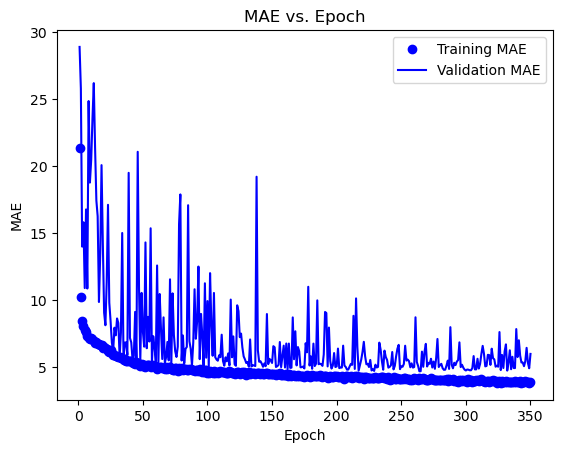

22/22 [==============================] - 7s 293ms/step
5.973


In [18]:
def make_doublemodel():
    X_train_duplicated = np.concatenate((X_train, X_train), axis=0)
    y_train_duplicated = np.concatenate((y_train, y_train), axis=0)

    model = get_model()
    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=['mean_absolute_error'])

    csv_logger = CSVLogger('/mnt/md0/tempFolder/Allen/Models/double_log.csv')

    checkpoint = ModelCheckpoint('/mnt/md0/tempFolder/Allen/Models/DoubleModel.h5', monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')
    history = model.fit(X_train_duplicated, y_train_duplicated, epochs=350, callbacks=[checkpoint, csv_logger], batch_size=14, validation_data=(X_test, y_test), verbose=1)

    # Get MAE values from training history
    train_mae = history.history['mean_absolute_error']
    val_mae = history.history['val_mean_absolute_error']
    epochs = range(1, len(train_mae) + 1)

    plt.figure()
    plt.plot(epochs, train_mae, 'bo', label='Training MAE')
    plt.plot(epochs, val_mae, 'b', label='Validation MAE')
    plt.title('MAE vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

    predictions = model.predict(X_test)

    mae = mean_absolute_error(y_test, predictions)
    print(mae)

    return history

model = make_doublemodel()


Rotated shape: (2804, 128, 128, 128)
Shifted shape: (2804, 128, 128, 128)
Scaled shape: (2804, 128, 128, 128)


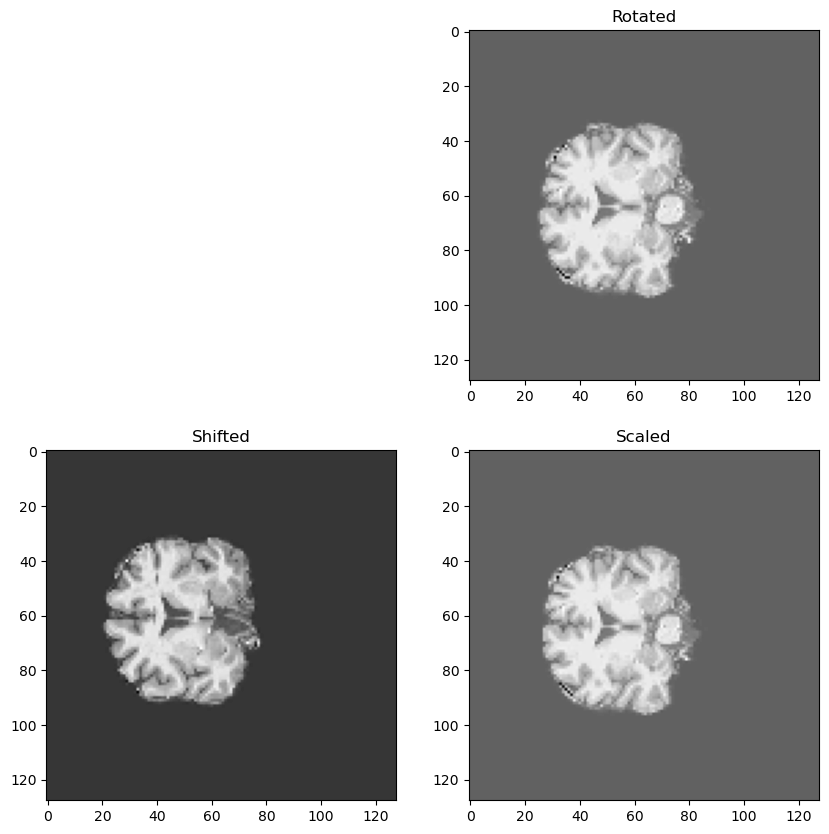

In [45]:
import numpy as np
from scipy.ndimage import gaussian_filter, shift, zoom
import cv2
import random
import matplotlib.pyplot as plt

# Function to rotate a 3D image by a random angle between -5 and 5 degrees
def random_rotate(X_train):
    rotated_images = []
    for image in X_train:
        # Create an empty array to store rotated 3D image
        angle_degrees = random.uniform(-5, 5)
        rotated_image = np.empty_like(image)

        # Loop through each depth slice
        for depth_slice in range(image.shape[2]):
            #changed to 3 degree rotation
            rotation_matrix = cv2.getRotationMatrix2D((image.shape[0] // 2, image.shape[1] // 2), angle_degrees, 1.0)
            # Ensure the image slice is of a supported type
            image_slice = image[:, :, depth_slice].astype('float32')
            rotated_slice = cv2.warpAffine(image_slice, rotation_matrix, (image.shape[1], image.shape[0]), flags = cv2.INTER_NEAREST)
            # Apply rotation to the depth slice
            # Store the blurred slice in the blurred 3D image
            rotated_image[:, :, depth_slice] = rotated_slice
        # Append the blurred 3D image to the list
        rotated_images.append(rotated_image)
    # Convert the list of rotated images to a NumPy array
    rotated_images = np.array(rotated_images)
    return rotated_images

# Function to shift a 3D image by a random vector between (0,0,0) and (5,5,5)
def random_shift(image):
    shift_vector = [random.uniform(-5, 5) for _ in range(3)]
    return shift(image, shift_vector, mode='constant', cval=0, order = 0)

# Function to scale a 3D image by a random factor between 0.95 and 1.05
def random_scale(X_train):
    import cv2
    scaled_images = []

    for image in X_train:
        scale = random.uniform(0.95, 1.05)
        # Create an empty array to store scaled 3D image
        scaled_image = np.empty_like(image)

        # Loop through each depth slice
        for depth_slice in range(image.shape[2]):

            #changed to 0 degree rotation
            rotation_matrix = cv2.getRotationMatrix2D((image.shape[0] // 2, image.shape[1] // 2), 0, scale)
            scaled_slice = cv2.warpAffine(image[:, :, depth_slice].astype('float32'), rotation_matrix, (image.shape[1], image.shape[0]), flags = cv2.INTER_NEAREST)
            # Apply scale to the depth slice

            # Store the scaled slice in the blurred 3D image
            scaled_image[:, :, depth_slice] = scaled_slice

        # Append the blurred 3D image to the list
        scaled_images.append(scaled_image)

    # Convert the list of rotated images to a NumPy array
    scaled_images = np.array(scaled_images)
    return scaled_images



# Apply transformations and trim/pad each image in the 3D training set
# X_train_blurred = np.array([gaussian_filter(x, sigma=1.5) for x in X_train])
X_train_rotated = random_rotate(X_train)
X_train_shifted = np.array([random_shift(x) for x in X_train])
X_train_scaled = random_scale(X_train)

# Print the shape of each transformed array
# print("Blurred shape:", X_train_blurred.shape)
print("Rotated shape:", X_train_rotated.shape)
print("Shifted shape:", X_train_shifted.shape)
print("Scaled shape:", X_train_scaled.shape)

# Save the transformed arrays
directory = '/mnt/md0/tempFolder/Allen/TrainTestData/'
# np.save(directory + 'Xtrainblurred' + '.npy', X_train_blurred)
np.save(directory + 'Xtrainrotated.npy', X_train_rotated)
np.save(directory + 'Xtraintranslated.npy', X_train_shifted)
np.save(directory + 'Xtrainscaled.npy', X_train_scaled)

# Plot an example from each transformed array
plt.figure(figsize=(10, 10))

# plt.subplot(2, 2, 1)
# plt.imshow(X_train_blurred[0, :, :, 64], cmap='gray')
# plt.title('Blurred')

plt.subplot(2, 2, 2)
plt.imshow(X_train_rotated[0, :, :, 64], cmap='gray')
plt.title('Rotated')

plt.subplot(2, 2, 3)
plt.imshow(X_train_shifted[0, :, :, 64], cmap='gray')
plt.title('Shifted')

plt.subplot(2, 2, 4)
plt.imshow(X_train_scaled[0, :, :, 64], cmap='gray')
plt.title('Scaled')

plt.show()


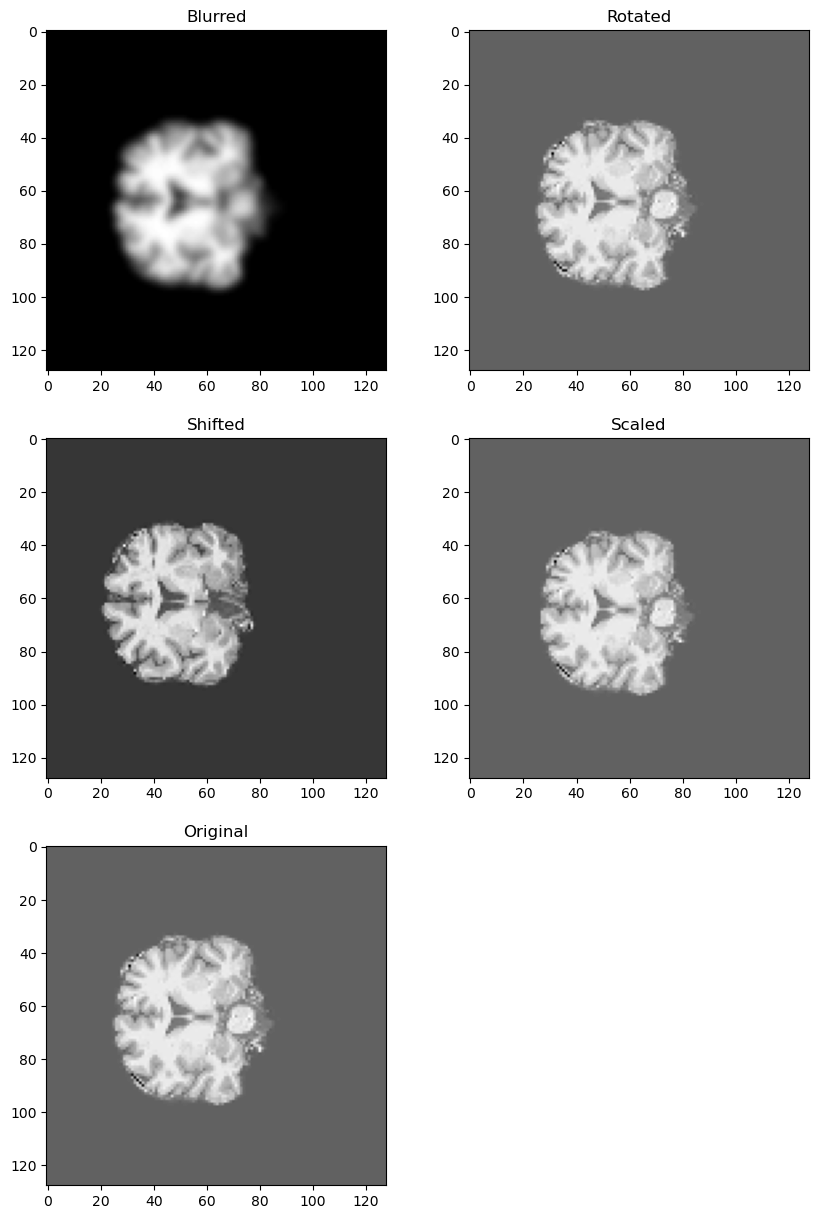

In [50]:
plt.figure(figsize=(10, 15))

plt.subplot(3, 2, 1)
plt.imshow(X_train_blurred[0, :, :, 64], cmap='gray')
plt.title('Blurred')

plt.subplot(3, 2, 2)
plt.imshow(X_train_rotated[0, :, :, 64], cmap='gray')
plt.title('Rotated')

plt.subplot(3, 2, 3)
plt.imshow(X_train_shifted[0, :, :, 64], cmap='gray')
plt.title('Shifted')

plt.subplot(3, 2, 4)
plt.imshow(X_train_scaled[0, :, :, 64], cmap='gray')
plt.title('Scaled')

plt.subplot(3, 2, 5)
plt.imshow(X_train[0, :, :, 64], cmap='gray')
plt.title('Original')

plt.savefig('/home/allenC/Downloads/Slices.png')
plt.show()


Epoch 1/350
401/401 [==============================] - ETA: 0s - loss: 22.2771 - mean_absolute_error: 22.2771
Epoch 1: val_mean_absolute_error improved from inf to 38.12630, saving model to /mnt/md0/tempFolder/Allen/Models/BlurredModel.h5
401/401 [==============================] - 207s 509ms/step - loss: 22.2771 - mean_absolute_error: 22.2771 - val_loss: 38.1263 - val_mean_absolute_error: 38.1263
Epoch 2/350


/mnt/md0/softwares/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


401/401 [==============================] - ETA: 0s - loss: 14.7298 - mean_absolute_error: 14.7298
Epoch 2: val_mean_absolute_error improved from 38.12630 to 10.01612, saving model to /mnt/md0/tempFolder/Allen/Models/BlurredModel.h5
401/401 [==============================] - 197s 492ms/step - loss: 14.7298 - mean_absolute_error: 14.7298 - val_loss: 10.0161 - val_mean_absolute_error: 10.0161
Epoch 3/350
401/401 [==============================] - ETA: 0s - loss: 11.5086 - mean_absolute_error: 11.5086
Epoch 3: val_mean_absolute_error improved from 10.01612 to 9.00357, saving model to /mnt/md0/tempFolder/Allen/Models/BlurredModel.h5
401/401 [==============================] - 197s 491ms/step - loss: 11.5086 - mean_absolute_error: 11.5086 - val_loss: 9.0036 - val_mean_absolute_error: 9.0036
Epoch 4/350
401/401 [==============================] - ETA: 0s - loss: 10.2264 - mean_absolute_error: 10.2264
Epoch 4: val_mean_absolute_error did not improve from 9.00357
401/401 [========================

401/401 [==============================] - 201s 500ms/step - loss: 6.8344 - mean_absolute_error: 6.8344 - val_loss: 5.7334 - val_mean_absolute_error: 5.7334
Epoch 26/350
401/401 [==============================] - ETA: 0s - loss: 6.9441 - mean_absolute_error: 6.9441
Epoch 26: val_mean_absolute_error improved from 5.64330 to 5.46752, saving model to /mnt/md0/tempFolder/Allen/Models/BlurredModel.h5
401/401 [==============================] - 197s 492ms/step - loss: 6.9441 - mean_absolute_error: 6.9441 - val_loss: 5.4675 - val_mean_absolute_error: 5.4675
Epoch 27/350
401/401 [==============================] - ETA: 0s - loss: 6.7545 - mean_absolute_error: 6.7545
Epoch 27: val_mean_absolute_error did not improve from 5.46752
401/401 [==============================] - 200s 499ms/step - loss: 6.7545 - mean_absolute_error: 6.7545 - val_loss: 7.5600 - val_mean_absolute_error: 7.5600
Epoch 28/350
401/401 [==============================] - ETA: 0s - loss: 6.6660 - mean_absolute_error: 6.6660
Epoch 

401/401 [==============================] - 195s 487ms/step - loss: 5.5570 - mean_absolute_error: 5.5570 - val_loss: 5.1523 - val_mean_absolute_error: 5.1523
Epoch 75/350
401/401 [==============================] - ETA: 0s - loss: 5.5752 - mean_absolute_error: 5.5752
Epoch 75: val_mean_absolute_error did not improve from 5.15232
401/401 [==============================] - 194s 484ms/step - loss: 5.5752 - mean_absolute_error: 5.5752 - val_loss: 5.5320 - val_mean_absolute_error: 5.5320
Epoch 76/350
401/401 [==============================] - ETA: 0s - loss: 5.5856 - mean_absolute_error: 5.5856
Epoch 76: val_mean_absolute_error did not improve from 5.15232
401/401 [==============================] - 194s 485ms/step - loss: 5.5856 - mean_absolute_error: 5.5856 - val_loss: 5.3379 - val_mean_absolute_error: 5.3379
Epoch 77/350
401/401 [==============================] - ETA: 0s - loss: 5.4146 - mean_absolute_error: 5.4146
Epoch 77: val_mean_absolute_error did not improve from 5.15232
401/401 [====

401/401 [==============================] - 199s 496ms/step - loss: 5.1035 - mean_absolute_error: 5.1035 - val_loss: 5.9423 - val_mean_absolute_error: 5.9423
Epoch 124/350
401/401 [==============================] - ETA: 0s - loss: 5.1474 - mean_absolute_error: 5.1474
Epoch 124: val_mean_absolute_error did not improve from 4.92275
401/401 [==============================] - 197s 492ms/step - loss: 5.1474 - mean_absolute_error: 5.1474 - val_loss: 5.4180 - val_mean_absolute_error: 5.4180
Epoch 125/350
401/401 [==============================] - ETA: 0s - loss: 5.1693 - mean_absolute_error: 5.1693
Epoch 125: val_mean_absolute_error did not improve from 4.92275
401/401 [==============================] - 198s 494ms/step - loss: 5.1693 - mean_absolute_error: 5.1693 - val_loss: 5.0027 - val_mean_absolute_error: 5.0027
Epoch 126/350
401/401 [==============================] - ETA: 0s - loss: 5.0422 - mean_absolute_error: 5.0422
Epoch 126: val_mean_absolute_error did not improve from 4.92275
401/401

Epoch 173/350
401/401 [==============================] - ETA: 0s - loss: 4.8925 - mean_absolute_error: 4.8925
Epoch 173: val_mean_absolute_error did not improve from 4.92275
401/401 [==============================] - 215s 535ms/step - loss: 4.8925 - mean_absolute_error: 4.8925 - val_loss: 4.9441 - val_mean_absolute_error: 4.9441
Epoch 174/350
401/401 [==============================] - ETA: 0s - loss: 4.9122 - mean_absolute_error: 4.9122
Epoch 174: val_mean_absolute_error did not improve from 4.92275
401/401 [==============================] - 215s 535ms/step - loss: 4.9122 - mean_absolute_error: 4.9122 - val_loss: 5.1267 - val_mean_absolute_error: 5.1267
Epoch 175/350
401/401 [==============================] - ETA: 0s - loss: 4.8963 - mean_absolute_error: 4.8963
Epoch 175: val_mean_absolute_error did not improve from 4.92275
401/401 [==============================] - 215s 536ms/step - loss: 4.8963 - mean_absolute_error: 4.8963 - val_loss: 5.4333 - val_mean_absolute_error: 5.4333
Epoch 1

Epoch 198/350
401/401 [==============================] - ETA: 0s - loss: 4.7024 - mean_absolute_error: 4.7024
Epoch 198: val_mean_absolute_error did not improve from 4.91046
401/401 [==============================] - 215s 537ms/step - loss: 4.7024 - mean_absolute_error: 4.7024 - val_loss: 5.4848 - val_mean_absolute_error: 5.4848
Epoch 199/350
401/401 [==============================] - ETA: 0s - loss: 4.9572 - mean_absolute_error: 4.9572
Epoch 199: val_mean_absolute_error did not improve from 4.91046
401/401 [==============================] - 215s 537ms/step - loss: 4.9572 - mean_absolute_error: 4.9572 - val_loss: 4.9568 - val_mean_absolute_error: 4.9568
Epoch 200/350
401/401 [==============================] - ETA: 0s - loss: 4.7915 - mean_absolute_error: 4.7915
Epoch 200: val_mean_absolute_error did not improve from 4.91046
401/401 [==============================] - 216s 538ms/step - loss: 4.7915 - mean_absolute_error: 4.7915 - val_loss: 5.4314 - val_mean_absolute_error: 5.4314
Epoch 2

Epoch 223/350
401/401 [==============================] - ETA: 0s - loss: 4.7506 - mean_absolute_error: 4.7506
Epoch 223: val_mean_absolute_error did not improve from 4.82106
401/401 [==============================] - 216s 538ms/step - loss: 4.7506 - mean_absolute_error: 4.7506 - val_loss: 5.4291 - val_mean_absolute_error: 5.4291
Epoch 224/350
401/401 [==============================] - ETA: 0s - loss: 4.9041 - mean_absolute_error: 4.9041
Epoch 224: val_mean_absolute_error did not improve from 4.82106
401/401 [==============================] - 215s 535ms/step - loss: 4.9041 - mean_absolute_error: 4.9041 - val_loss: 5.3630 - val_mean_absolute_error: 5.3630
Epoch 225/350
401/401 [==============================] - ETA: 0s - loss: 4.6960 - mean_absolute_error: 4.6960
Epoch 225: val_mean_absolute_error did not improve from 4.82106
401/401 [==============================] - 216s 538ms/step - loss: 4.6960 - mean_absolute_error: 4.6960 - val_loss: 5.0948 - val_mean_absolute_error: 5.0948
Epoch 2

Epoch 248/350
401/401 [==============================] - ETA: 0s - loss: 4.7462 - mean_absolute_error: 4.7462
Epoch 248: val_mean_absolute_error did not improve from 4.82106
401/401 [==============================] - 214s 533ms/step - loss: 4.7462 - mean_absolute_error: 4.7462 - val_loss: 4.9350 - val_mean_absolute_error: 4.9350
Epoch 249/350
401/401 [==============================] - ETA: 0s - loss: 4.7548 - mean_absolute_error: 4.7548
Epoch 249: val_mean_absolute_error did not improve from 4.82106
401/401 [==============================] - 215s 536ms/step - loss: 4.7548 - mean_absolute_error: 4.7548 - val_loss: 4.9377 - val_mean_absolute_error: 4.9377
Epoch 250/350
401/401 [==============================] - ETA: 0s - loss: 4.6401 - mean_absolute_error: 4.6401
Epoch 250: val_mean_absolute_error did not improve from 4.82106
401/401 [==============================] - 215s 536ms/step - loss: 4.6401 - mean_absolute_error: 4.6401 - val_loss: 4.9351 - val_mean_absolute_error: 4.9351
Epoch 2

Epoch 297/350
401/401 [==============================] - ETA: 0s - loss: 4.6586 - mean_absolute_error: 4.6586
Epoch 297: val_mean_absolute_error did not improve from 4.74292
401/401 [==============================] - 214s 534ms/step - loss: 4.6586 - mean_absolute_error: 4.6586 - val_loss: 5.1424 - val_mean_absolute_error: 5.1424
Epoch 298/350
401/401 [==============================] - ETA: 0s - loss: 4.6036 - mean_absolute_error: 4.6036
Epoch 298: val_mean_absolute_error did not improve from 4.74292
401/401 [==============================] - 214s 534ms/step - loss: 4.6036 - mean_absolute_error: 4.6036 - val_loss: 5.0297 - val_mean_absolute_error: 5.0297
Epoch 299/350
401/401 [==============================] - ETA: 0s - loss: 4.5905 - mean_absolute_error: 4.5905
Epoch 299: val_mean_absolute_error did not improve from 4.74292
401/401 [==============================] - 213s 532ms/step - loss: 4.5905 - mean_absolute_error: 4.5905 - val_loss: 4.8494 - val_mean_absolute_error: 4.8494
Epoch 3

Epoch 322/350
401/401 [==============================] - ETA: 0s - loss: 4.4472 - mean_absolute_error: 4.4472
Epoch 322: val_mean_absolute_error did not improve from 4.74292
401/401 [==============================] - 214s 534ms/step - loss: 4.4472 - mean_absolute_error: 4.4472 - val_loss: 4.9923 - val_mean_absolute_error: 4.9923
Epoch 323/350
401/401 [==============================] - ETA: 0s - loss: 4.4001 - mean_absolute_error: 4.4001
Epoch 323: val_mean_absolute_error did not improve from 4.74292
401/401 [==============================] - 214s 533ms/step - loss: 4.4001 - mean_absolute_error: 4.4001 - val_loss: 4.9766 - val_mean_absolute_error: 4.9766
Epoch 324/350
401/401 [==============================] - ETA: 0s - loss: 4.4457 - mean_absolute_error: 4.4457
Epoch 324: val_mean_absolute_error did not improve from 4.74292
401/401 [==============================] - 214s 533ms/step - loss: 4.4457 - mean_absolute_error: 4.4457 - val_loss: 5.1543 - val_mean_absolute_error: 5.1543
Epoch 3

Epoch 347/350
401/401 [==============================] - ETA: 0s - loss: 4.3978 - mean_absolute_error: 4.3978
Epoch 347: val_mean_absolute_error did not improve from 4.74292
401/401 [==============================] - 214s 533ms/step - loss: 4.3978 - mean_absolute_error: 4.3978 - val_loss: 5.3129 - val_mean_absolute_error: 5.3129
Epoch 348/350
401/401 [==============================] - ETA: 0s - loss: 4.3226 - mean_absolute_error: 4.3226
Epoch 348: val_mean_absolute_error did not improve from 4.74292
401/401 [==============================] - 213s 532ms/step - loss: 4.3226 - mean_absolute_error: 4.3226 - val_loss: 4.8852 - val_mean_absolute_error: 4.8852
Epoch 349/350
401/401 [==============================] - ETA: 0s - loss: 4.4354 - mean_absolute_error: 4.4354
Epoch 349: val_mean_absolute_error did not improve from 4.74292
401/401 [==============================] - 214s 533ms/step - loss: 4.4354 - mean_absolute_error: 4.4354 - val_loss: 5.2147 - val_mean_absolute_error: 5.2147
Epoch 3

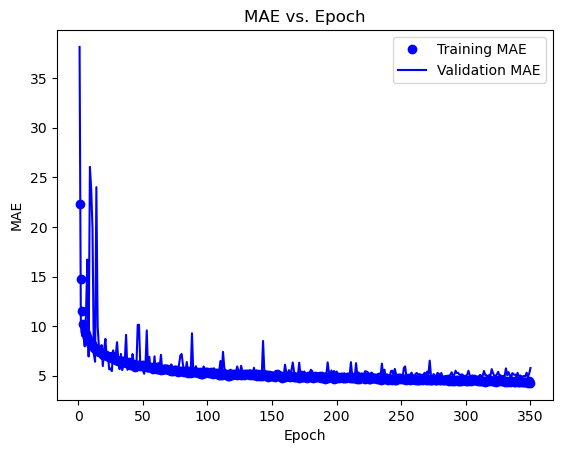

22/22 [==============================] - 6s 286ms/step
5.782296


In [41]:
directory = '/mnt/md0/tempFolder/Allen/TrainTestData/'
def make_blurredmodel():
    Xaugmentedblurred_train = np.concatenate((X_train, X_train_blurred), axis = 0)
    y_train_duplicated = np.concatenate((y_train, y_train), axis = 0)
    model = get_model()
    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=['mean_absolute_error'])

    csv_logger = CSVLogger('/mnt/md0/tempFolder/Allen/Models/Blurred_log.csv')

    checkpoint = ModelCheckpoint('/mnt/md0/tempFolder/Allen/Models/BlurredModel.h5', monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')
    history = model.fit(Xaugmentedblurred_train, y_train_duplicated, epochs=350, callbacks=[checkpoint, csv_logger], batch_size=14, validation_data=(X_test, y_test), verbose=1)

    # Get MAE values from training history
    train_mae = history.history['mean_absolute_error']
    val_mae = history.history['val_mean_absolute_error']
    epochs = range(1, len(train_mae) + 1)

    plt.figure()
    plt.plot(epochs, train_mae, 'bo', label='Training MAE')
    plt.plot(epochs, val_mae, 'b', label='Validation MAE')
    plt.title('MAE vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

    predictions = model.predict(X_test)

    mae = mean_absolute_error(y_test, predictions)
    print(mae)

    return history

model = make_blurredmodel()


Epoch 1/350
401/401 [==============================] - ETA: 0s - loss: 25.7348 - mean_absolute_error: 25.7348
Epoch 1: val_mean_absolute_error improved from inf to 10.32036, saving model to /mnt/md0/tempFolder/Allen/Models/ScaledModel.h5
401/401 [==============================] - 206s 509ms/step - loss: 25.7348 - mean_absolute_error: 25.7348 - val_loss: 10.3204 - val_mean_absolute_error: 10.3204
Epoch 2/350


/mnt/md0/softwares/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


401/401 [==============================] - ETA: 0s - loss: 10.9152 - mean_absolute_error: 10.9152
Epoch 2: val_mean_absolute_error did not improve from 10.32036
401/401 [==============================] - 200s 498ms/step - loss: 10.9152 - mean_absolute_error: 10.9152 - val_loss: 15.8541 - val_mean_absolute_error: 15.8541
Epoch 3/350
401/401 [==============================] - ETA: 0s - loss: 8.8084 - mean_absolute_error: 8.8084
Epoch 3: val_mean_absolute_error did not improve from 10.32036
401/401 [==============================] - 198s 494ms/step - loss: 8.8084 - mean_absolute_error: 8.8084 - val_loss: 12.5192 - val_mean_absolute_error: 12.5192
Epoch 4/350
401/401 [==============================] - ETA: 0s - loss: 8.3446 - mean_absolute_error: 8.3446
Epoch 4: val_mean_absolute_error improved from 10.32036 to 9.46715, saving model to /mnt/md0/tempFolder/Allen/Models/ScaledModel.h5
401/401 [==============================] - 199s 496ms/step - loss: 8.3446 - mean_absolute_error: 8.3446 - va

401/401 [==============================] - 196s 490ms/step - loss: 6.0761 - mean_absolute_error: 6.0761 - val_loss: 6.1060 - val_mean_absolute_error: 6.1060
Epoch 26/350
401/401 [==============================] - ETA: 0s - loss: 6.1769 - mean_absolute_error: 6.1769
Epoch 26: val_mean_absolute_error improved from 5.47320 to 5.43339, saving model to /mnt/md0/tempFolder/Allen/Models/ScaledModel.h5
401/401 [==============================] - 196s 489ms/step - loss: 6.1769 - mean_absolute_error: 6.1769 - val_loss: 5.4334 - val_mean_absolute_error: 5.4334
Epoch 27/350
401/401 [==============================] - ETA: 0s - loss: 5.9956 - mean_absolute_error: 5.9956
Epoch 27: val_mean_absolute_error did not improve from 5.43339
401/401 [==============================] - 195s 487ms/step - loss: 5.9956 - mean_absolute_error: 5.9956 - val_loss: 9.3010 - val_mean_absolute_error: 9.3010
Epoch 28/350
401/401 [==============================] - ETA: 0s - loss: 6.0735 - mean_absolute_error: 6.0735
Epoch 2

Epoch 50/350
401/401 [==============================] - ETA: 0s - loss: 5.4232 - mean_absolute_error: 5.4232
Epoch 50: val_mean_absolute_error did not improve from 5.20118
401/401 [==============================] - 205s 512ms/step - loss: 5.4232 - mean_absolute_error: 5.4232 - val_loss: 5.5711 - val_mean_absolute_error: 5.5711
Epoch 51/350
401/401 [==============================] - ETA: 0s - loss: 5.4149 - mean_absolute_error: 5.4149
Epoch 51: val_mean_absolute_error did not improve from 5.20118
401/401 [==============================] - 206s 514ms/step - loss: 5.4149 - mean_absolute_error: 5.4149 - val_loss: 5.6200 - val_mean_absolute_error: 5.6200
Epoch 52/350
401/401 [==============================] - ETA: 0s - loss: 5.2913 - mean_absolute_error: 5.2913
Epoch 52: val_mean_absolute_error did not improve from 5.20118
401/401 [==============================] - 205s 511ms/step - loss: 5.2913 - mean_absolute_error: 5.2913 - val_loss: 5.9047 - val_mean_absolute_error: 5.9047
Epoch 53/350


401/401 [==============================] - 205s 512ms/step - loss: 5.2756 - mean_absolute_error: 5.2756 - val_loss: 5.4980 - val_mean_absolute_error: 5.4980
Epoch 75/350
401/401 [==============================] - ETA: 0s - loss: 5.1277 - mean_absolute_error: 5.1277
Epoch 75: val_mean_absolute_error did not improve from 5.05271
401/401 [==============================] - 206s 514ms/step - loss: 5.1277 - mean_absolute_error: 5.1277 - val_loss: 7.7964 - val_mean_absolute_error: 7.7964
Epoch 76/350
401/401 [==============================] - ETA: 0s - loss: 5.2414 - mean_absolute_error: 5.2414
Epoch 76: val_mean_absolute_error did not improve from 5.05271
401/401 [==============================] - 207s 515ms/step - loss: 5.2414 - mean_absolute_error: 5.2414 - val_loss: 6.2368 - val_mean_absolute_error: 6.2368
Epoch 77/350
401/401 [==============================] - ETA: 0s - loss: 5.1999 - mean_absolute_error: 5.1999
Epoch 77: val_mean_absolute_error did not improve from 5.05271
401/401 [====

401/401 [==============================] - 198s 493ms/step - loss: 4.9346 - mean_absolute_error: 4.9346 - val_loss: 5.8555 - val_mean_absolute_error: 5.8555
Epoch 124/350
401/401 [==============================] - ETA: 0s - loss: 4.9588 - mean_absolute_error: 4.9588
Epoch 124: val_mean_absolute_error did not improve from 4.89636
401/401 [==============================] - 196s 490ms/step - loss: 4.9588 - mean_absolute_error: 4.9588 - val_loss: 5.5798 - val_mean_absolute_error: 5.5798
Epoch 125/350
401/401 [==============================] - ETA: 0s - loss: 4.9674 - mean_absolute_error: 4.9674
Epoch 125: val_mean_absolute_error did not improve from 4.89636
401/401 [==============================] - 196s 489ms/step - loss: 4.9674 - mean_absolute_error: 4.9674 - val_loss: 4.9412 - val_mean_absolute_error: 4.9412
Epoch 126/350
401/401 [==============================] - ETA: 0s - loss: 4.8789 - mean_absolute_error: 4.8789
Epoch 126: val_mean_absolute_error did not improve from 4.89636
401/401

401/401 [==============================] - 206s 514ms/step - loss: 4.8626 - mean_absolute_error: 4.8626 - val_loss: 5.7015 - val_mean_absolute_error: 5.7015
Epoch 173/350
401/401 [==============================] - ETA: 0s - loss: 4.8769 - mean_absolute_error: 4.8769
Epoch 173: val_mean_absolute_error did not improve from 4.87129
401/401 [==============================] - 206s 513ms/step - loss: 4.8769 - mean_absolute_error: 4.8769 - val_loss: 8.2042 - val_mean_absolute_error: 8.2042
Epoch 174/350
401/401 [==============================] - ETA: 0s - loss: 4.9982 - mean_absolute_error: 4.9982
Epoch 174: val_mean_absolute_error did not improve from 4.87129
401/401 [==============================] - 206s 515ms/step - loss: 4.9982 - mean_absolute_error: 4.9982 - val_loss: 4.8814 - val_mean_absolute_error: 4.8814
Epoch 175/350
401/401 [==============================] - ETA: 0s - loss: 4.8104 - mean_absolute_error: 4.8104
Epoch 175: val_mean_absolute_error did not improve from 4.87129
401/401

Epoch 222/350
401/401 [==============================] - ETA: 0s - loss: 4.6077 - mean_absolute_error: 4.6077
Epoch 222: val_mean_absolute_error did not improve from 4.79823
401/401 [==============================] - 214s 534ms/step - loss: 4.6077 - mean_absolute_error: 4.6077 - val_loss: 5.2068 - val_mean_absolute_error: 5.2068
Epoch 223/350
401/401 [==============================] - ETA: 0s - loss: 4.6830 - mean_absolute_error: 4.6830
Epoch 223: val_mean_absolute_error did not improve from 4.79823
401/401 [==============================] - 215s 535ms/step - loss: 4.6830 - mean_absolute_error: 4.6830 - val_loss: 4.8960 - val_mean_absolute_error: 4.8960
Epoch 224/350
401/401 [==============================] - ETA: 0s - loss: 4.7300 - mean_absolute_error: 4.7300
Epoch 224: val_mean_absolute_error did not improve from 4.79823
401/401 [==============================] - 216s 537ms/step - loss: 4.7300 - mean_absolute_error: 4.7300 - val_loss: 6.0257 - val_mean_absolute_error: 6.0257
Epoch 2

Epoch 247/350
401/401 [==============================] - ETA: 0s - loss: 4.4725 - mean_absolute_error: 4.4725
Epoch 247: val_mean_absolute_error did not improve from 4.75438
401/401 [==============================] - 214s 534ms/step - loss: 4.4725 - mean_absolute_error: 4.4725 - val_loss: 5.4735 - val_mean_absolute_error: 5.4735
Epoch 248/350
401/401 [==============================] - ETA: 0s - loss: 4.5509 - mean_absolute_error: 4.5509
Epoch 248: val_mean_absolute_error did not improve from 4.75438
401/401 [==============================] - 215s 536ms/step - loss: 4.5509 - mean_absolute_error: 4.5509 - val_loss: 5.1985 - val_mean_absolute_error: 5.1985
Epoch 249/350
401/401 [==============================] - ETA: 0s - loss: 4.4940 - mean_absolute_error: 4.4940
Epoch 249: val_mean_absolute_error did not improve from 4.75438
401/401 [==============================] - 213s 531ms/step - loss: 4.4940 - mean_absolute_error: 4.4940 - val_loss: 5.4527 - val_mean_absolute_error: 5.4527
Epoch 2

Epoch 272/350
401/401 [==============================] - ETA: 0s - loss: 4.5395 - mean_absolute_error: 4.5395
Epoch 272: val_mean_absolute_error did not improve from 4.74494
401/401 [==============================] - 214s 533ms/step - loss: 4.5395 - mean_absolute_error: 4.5395 - val_loss: 4.9594 - val_mean_absolute_error: 4.9594
Epoch 273/350
401/401 [==============================] - ETA: 0s - loss: 4.5108 - mean_absolute_error: 4.5108
Epoch 273: val_mean_absolute_error did not improve from 4.74494
401/401 [==============================] - 213s 531ms/step - loss: 4.5108 - mean_absolute_error: 4.5108 - val_loss: 4.8120 - val_mean_absolute_error: 4.8120
Epoch 274/350
401/401 [==============================] - ETA: 0s - loss: 4.4544 - mean_absolute_error: 4.4544
Epoch 274: val_mean_absolute_error did not improve from 4.74494
401/401 [==============================] - 213s 531ms/step - loss: 4.4544 - mean_absolute_error: 4.4544 - val_loss: 4.9101 - val_mean_absolute_error: 4.9101
Epoch 2

Epoch 297/350
401/401 [==============================] - ETA: 0s - loss: 4.4403 - mean_absolute_error: 4.4403
Epoch 297: val_mean_absolute_error did not improve from 4.72012
401/401 [==============================] - 213s 532ms/step - loss: 4.4403 - mean_absolute_error: 4.4403 - val_loss: 4.8070 - val_mean_absolute_error: 4.8070
Epoch 298/350
401/401 [==============================] - ETA: 0s - loss: 4.3598 - mean_absolute_error: 4.3598
Epoch 298: val_mean_absolute_error did not improve from 4.72012
401/401 [==============================] - 214s 534ms/step - loss: 4.3598 - mean_absolute_error: 4.3598 - val_loss: 5.0260 - val_mean_absolute_error: 5.0260
Epoch 299/350
401/401 [==============================] - ETA: 0s - loss: 4.4229 - mean_absolute_error: 4.4229
Epoch 299: val_mean_absolute_error did not improve from 4.72012
401/401 [==============================] - 214s 535ms/step - loss: 4.4229 - mean_absolute_error: 4.4229 - val_loss: 5.1838 - val_mean_absolute_error: 5.1838
Epoch 3

Epoch 322/350
401/401 [==============================] - ETA: 0s - loss: 4.4217 - mean_absolute_error: 4.4217
Epoch 322: val_mean_absolute_error did not improve from 4.72012
401/401 [==============================] - 214s 533ms/step - loss: 4.4217 - mean_absolute_error: 4.4217 - val_loss: 5.4784 - val_mean_absolute_error: 5.4784
Epoch 323/350
401/401 [==============================] - ETA: 0s - loss: 4.4652 - mean_absolute_error: 4.4652
Epoch 323: val_mean_absolute_error did not improve from 4.72012
401/401 [==============================] - 214s 533ms/step - loss: 4.4652 - mean_absolute_error: 4.4652 - val_loss: 5.4589 - val_mean_absolute_error: 5.4589
Epoch 324/350
401/401 [==============================] - ETA: 0s - loss: 4.3845 - mean_absolute_error: 4.3845
Epoch 324: val_mean_absolute_error did not improve from 4.72012
401/401 [==============================] - 214s 533ms/step - loss: 4.3845 - mean_absolute_error: 4.3845 - val_loss: 4.9156 - val_mean_absolute_error: 4.9156
Epoch 3

Epoch 347/350
401/401 [==============================] - ETA: 0s - loss: 4.2444 - mean_absolute_error: 4.2444
Epoch 347: val_mean_absolute_error did not improve from 4.69185
401/401 [==============================] - 224s 558ms/step - loss: 4.2444 - mean_absolute_error: 4.2444 - val_loss: 5.2975 - val_mean_absolute_error: 5.2975
Epoch 348/350
401/401 [==============================] - ETA: 0s - loss: 4.2669 - mean_absolute_error: 4.2669
Epoch 348: val_mean_absolute_error did not improve from 4.69185
401/401 [==============================] - 214s 534ms/step - loss: 4.2669 - mean_absolute_error: 4.2669 - val_loss: 4.7602 - val_mean_absolute_error: 4.7602
Epoch 349/350
401/401 [==============================] - ETA: 0s - loss: 4.3525 - mean_absolute_error: 4.3525
Epoch 349: val_mean_absolute_error did not improve from 4.69185
401/401 [==============================] - 214s 533ms/step - loss: 4.3525 - mean_absolute_error: 4.3525 - val_loss: 4.7547 - val_mean_absolute_error: 4.7547
Epoch 3

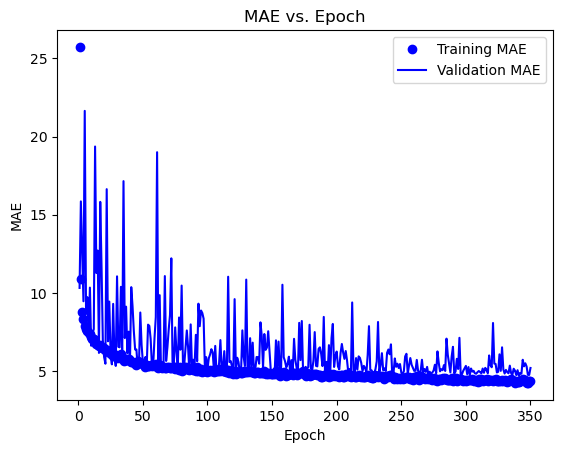

22/22 [==============================] - 6s 286ms/step
5.200103


In [49]:
directory = '/mnt/md0/tempFolder/Allen/TrainTestData/'
def make_scaledmodel():
    Xaugmentedscaled_train = np.concatenate((X_train, X_train_scaled), axis = 0)
    y_train_duplicated = np.concatenate((y_train, y_train), axis = 0)
    model = get_model()
    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=['mean_absolute_error'])

    csv_logger = CSVLogger('/mnt/md0/tempFolder/Allen/Models/Scaled_log.csv')

    checkpoint = ModelCheckpoint('/mnt/md0/tempFolder/Allen/Models/ScaledModel.h5', monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')
    history = model.fit(Xaugmentedscaled_train, y_train_duplicated, epochs=350, callbacks=[checkpoint, csv_logger], batch_size=14, validation_data=(X_test, y_test), verbose=1)

    # Get MAE values from training history
    train_mae = history.history['mean_absolute_error']
    val_mae = history.history['val_mean_absolute_error']
    epochs = range(1, len(train_mae) + 1)

    plt.figure()
    plt.plot(epochs, train_mae, 'bo', label='Training MAE')
    plt.plot(epochs, val_mae, 'b', label='Validation MAE')
    plt.title('MAE vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

    predictions = model.predict(X_test)

    mae = mean_absolute_error(y_test, predictions)
    print(mae)

    return history

model = make_scaledmodel()

Epoch 1/350
401/401 [==============================] - ETA: 0s - loss: 23.6356 - mean_absolute_error: 23.6356
Epoch 1: val_mean_absolute_error improved from inf to 75.89157, saving model to /mnt/md0/tempFolder/Allen/Models/RotatedModel.h5
401/401 [==============================] - 207s 513ms/step - loss: 23.6356 - mean_absolute_error: 23.6356 - val_loss: 75.8916 - val_mean_absolute_error: 75.8916
Epoch 2/350


/mnt/md0/softwares/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


401/401 [==============================] - ETA: 0s - loss: 9.3005 - mean_absolute_error: 9.3005
Epoch 2: val_mean_absolute_error improved from 75.89157 to 20.51450, saving model to /mnt/md0/tempFolder/Allen/Models/RotatedModel.h5
401/401 [==============================] - 208s 518ms/step - loss: 9.3005 - mean_absolute_error: 9.3005 - val_loss: 20.5145 - val_mean_absolute_error: 20.5145
Epoch 3/350
401/401 [==============================] - ETA: 0s - loss: 8.5592 - mean_absolute_error: 8.5592
Epoch 3: val_mean_absolute_error did not improve from 20.51450
401/401 [==============================] - 206s 515ms/step - loss: 8.5592 - mean_absolute_error: 8.5592 - val_loss: 30.3047 - val_mean_absolute_error: 30.3047
Epoch 4/350
401/401 [==============================] - ETA: 0s - loss: 7.9203 - mean_absolute_error: 7.9203
Epoch 4: val_mean_absolute_error did not improve from 20.51450
401/401 [==============================] - 207s 515ms/step - loss: 7.9203 - mean_absolute_error: 7.9203 - val_

Epoch 26/350
401/401 [==============================] - ETA: 0s - loss: 6.2080 - mean_absolute_error: 6.2080
Epoch 26: val_mean_absolute_error did not improve from 7.15605
401/401 [==============================] - 205s 511ms/step - loss: 6.2080 - mean_absolute_error: 6.2080 - val_loss: 7.1986 - val_mean_absolute_error: 7.1986
Epoch 27/350
401/401 [==============================] - ETA: 0s - loss: 6.2370 - mean_absolute_error: 6.2370
Epoch 27: val_mean_absolute_error did not improve from 7.15605
401/401 [==============================] - 206s 514ms/step - loss: 6.2370 - mean_absolute_error: 6.2370 - val_loss: 13.4591 - val_mean_absolute_error: 13.4591
Epoch 28/350
401/401 [==============================] - ETA: 0s - loss: 6.0477 - mean_absolute_error: 6.0477
Epoch 28: val_mean_absolute_error did not improve from 7.15605
401/401 [==============================] - 206s 513ms/step - loss: 6.0477 - mean_absolute_error: 6.0477 - val_loss: 16.3102 - val_mean_absolute_error: 16.3102
Epoch 29/

Epoch 50/350
401/401 [==============================] - ETA: 0s - loss: 5.3921 - mean_absolute_error: 5.3921
Epoch 50: val_mean_absolute_error did not improve from 5.09536
401/401 [==============================] - 211s 527ms/step - loss: 5.3921 - mean_absolute_error: 5.3921 - val_loss: 5.2287 - val_mean_absolute_error: 5.2287
Epoch 51/350
401/401 [==============================] - ETA: 0s - loss: 5.3924 - mean_absolute_error: 5.3924
Epoch 51: val_mean_absolute_error improved from 5.09536 to 4.98270, saving model to /mnt/md0/tempFolder/Allen/Models/RotatedModel.h5
401/401 [==============================] - 212s 527ms/step - loss: 5.3924 - mean_absolute_error: 5.3924 - val_loss: 4.9827 - val_mean_absolute_error: 4.9827
Epoch 52/350
401/401 [==============================] - ETA: 0s - loss: 5.3314 - mean_absolute_error: 5.3314
Epoch 52: val_mean_absolute_error did not improve from 4.98270
401/401 [==============================] - 211s 526ms/step - loss: 5.3314 - mean_absolute_error: 5.3

401/401 [==============================] - 209s 522ms/step - loss: 5.1166 - mean_absolute_error: 5.1166 - val_loss: 12.9377 - val_mean_absolute_error: 12.9377
Epoch 75/350
401/401 [==============================] - ETA: 0s - loss: 5.1669 - mean_absolute_error: 5.1669
Epoch 75: val_mean_absolute_error did not improve from 4.95043
401/401 [==============================] - 209s 520ms/step - loss: 5.1669 - mean_absolute_error: 5.1669 - val_loss: 9.7441 - val_mean_absolute_error: 9.7441
Epoch 76/350
401/401 [==============================] - ETA: 0s - loss: 5.1074 - mean_absolute_error: 5.1074
Epoch 76: val_mean_absolute_error did not improve from 4.95043
401/401 [==============================] - 208s 519ms/step - loss: 5.1074 - mean_absolute_error: 5.1074 - val_loss: 9.1005 - val_mean_absolute_error: 9.1005
Epoch 77/350
401/401 [==============================] - ETA: 0s - loss: 5.1358 - mean_absolute_error: 5.1358
Epoch 77: val_mean_absolute_error did not improve from 4.95043
401/401 [==

Epoch 124/350
401/401 [==============================] - ETA: 0s - loss: 4.8019 - mean_absolute_error: 4.8019
Epoch 124: val_mean_absolute_error did not improve from 4.74756
401/401 [==============================] - 194s 485ms/step - loss: 4.8019 - mean_absolute_error: 4.8019 - val_loss: 9.2068 - val_mean_absolute_error: 9.2068
Epoch 125/350
401/401 [==============================] - ETA: 0s - loss: 4.8146 - mean_absolute_error: 4.8146
Epoch 125: val_mean_absolute_error did not improve from 4.74756
401/401 [==============================] - 195s 486ms/step - loss: 4.8146 - mean_absolute_error: 4.8146 - val_loss: 7.4367 - val_mean_absolute_error: 7.4367
Epoch 126/350
401/401 [==============================] - ETA: 0s - loss: 4.8285 - mean_absolute_error: 4.8285
Epoch 126: val_mean_absolute_error did not improve from 4.74756
401/401 [==============================] - 195s 486ms/step - loss: 4.8285 - mean_absolute_error: 4.8285 - val_loss: 5.1046 - val_mean_absolute_error: 5.1046
Epoch 1

Epoch 149/350
401/401 [==============================] - ETA: 0s - loss: 4.6140 - mean_absolute_error: 4.6140
Epoch 149: val_mean_absolute_error did not improve from 4.74756
401/401 [==============================] - 202s 504ms/step - loss: 4.6140 - mean_absolute_error: 4.6140 - val_loss: 4.8964 - val_mean_absolute_error: 4.8964
Epoch 150/350
401/401 [==============================] - ETA: 0s - loss: 4.7399 - mean_absolute_error: 4.7399
Epoch 150: val_mean_absolute_error did not improve from 4.74756
401/401 [==============================] - 201s 501ms/step - loss: 4.7399 - mean_absolute_error: 4.7399 - val_loss: 10.8679 - val_mean_absolute_error: 10.8679
Epoch 151/350
401/401 [==============================] - ETA: 0s - loss: 4.6654 - mean_absolute_error: 4.6654
Epoch 151: val_mean_absolute_error did not improve from 4.74756
401/401 [==============================] - 201s 502ms/step - loss: 4.6654 - mean_absolute_error: 4.6654 - val_loss: 4.9697 - val_mean_absolute_error: 4.9697
Epoch

Epoch 174/350
401/401 [==============================] - ETA: 0s - loss: 4.7046 - mean_absolute_error: 4.7046
Epoch 174: val_mean_absolute_error did not improve from 4.67608
401/401 [==============================] - 200s 499ms/step - loss: 4.7046 - mean_absolute_error: 4.7046 - val_loss: 6.6374 - val_mean_absolute_error: 6.6374
Epoch 175/350
401/401 [==============================] - ETA: 0s - loss: 4.4606 - mean_absolute_error: 4.4606
Epoch 175: val_mean_absolute_error did not improve from 4.67608
401/401 [==============================] - 201s 502ms/step - loss: 4.4606 - mean_absolute_error: 4.4606 - val_loss: 9.1623 - val_mean_absolute_error: 9.1623
Epoch 176/350
401/401 [==============================] - ETA: 0s - loss: 4.6823 - mean_absolute_error: 4.6823
Epoch 176: val_mean_absolute_error did not improve from 4.67608
401/401 [==============================] - 204s 510ms/step - loss: 4.6823 - mean_absolute_error: 4.6823 - val_loss: 5.0027 - val_mean_absolute_error: 5.0027
Epoch 1

Epoch 199/350
401/401 [==============================] - ETA: 0s - loss: 4.6024 - mean_absolute_error: 4.6024
Epoch 199: val_mean_absolute_error did not improve from 4.67608
401/401 [==============================] - 210s 524ms/step - loss: 4.6024 - mean_absolute_error: 4.6024 - val_loss: 7.5356 - val_mean_absolute_error: 7.5356
Epoch 200/350
401/401 [==============================] - ETA: 0s - loss: 4.4555 - mean_absolute_error: 4.4555
Epoch 200: val_mean_absolute_error did not improve from 4.67608
401/401 [==============================] - 210s 523ms/step - loss: 4.4555 - mean_absolute_error: 4.4555 - val_loss: 8.0940 - val_mean_absolute_error: 8.0940
Epoch 201/350
401/401 [==============================] - ETA: 0s - loss: 4.5235 - mean_absolute_error: 4.5235
Epoch 201: val_mean_absolute_error did not improve from 4.67608
401/401 [==============================] - 209s 522ms/step - loss: 4.5235 - mean_absolute_error: 4.5235 - val_loss: 5.8702 - val_mean_absolute_error: 5.8702
Epoch 2

Epoch 224/350
401/401 [==============================] - ETA: 0s - loss: 4.3919 - mean_absolute_error: 4.3919
Epoch 224: val_mean_absolute_error did not improve from 4.67608
401/401 [==============================] - 208s 519ms/step - loss: 4.3919 - mean_absolute_error: 4.3919 - val_loss: 8.2972 - val_mean_absolute_error: 8.2972
Epoch 225/350
401/401 [==============================] - ETA: 0s - loss: 4.4090 - mean_absolute_error: 4.4090
Epoch 225: val_mean_absolute_error did not improve from 4.67608
401/401 [==============================] - 209s 521ms/step - loss: 4.4090 - mean_absolute_error: 4.4090 - val_loss: 4.9974 - val_mean_absolute_error: 4.9974
Epoch 226/350
401/401 [==============================] - ETA: 0s - loss: 4.4496 - mean_absolute_error: 4.4496
Epoch 226: val_mean_absolute_error did not improve from 4.67608
401/401 [==============================] - 209s 520ms/step - loss: 4.4496 - mean_absolute_error: 4.4496 - val_loss: 5.5320 - val_mean_absolute_error: 5.5320
Epoch 2

Epoch 249/350
401/401 [==============================] - ETA: 0s - loss: 4.3881 - mean_absolute_error: 4.3881
Epoch 249: val_mean_absolute_error improved from 4.67608 to 4.65140, saving model to /mnt/md0/tempFolder/Allen/Models/RotatedModel.h5
401/401 [==============================] - 209s 522ms/step - loss: 4.3881 - mean_absolute_error: 4.3881 - val_loss: 4.6514 - val_mean_absolute_error: 4.6514
Epoch 250/350
401/401 [==============================] - ETA: 0s - loss: 4.3475 - mean_absolute_error: 4.3475
Epoch 250: val_mean_absolute_error did not improve from 4.65140
401/401 [==============================] - 209s 521ms/step - loss: 4.3475 - mean_absolute_error: 4.3475 - val_loss: 6.5385 - val_mean_absolute_error: 6.5385
Epoch 251/350
401/401 [==============================] - ETA: 0s - loss: 4.3095 - mean_absolute_error: 4.3095
Epoch 251: val_mean_absolute_error did not improve from 4.65140
401/401 [==============================] - 210s 523ms/step - loss: 4.3095 - mean_absolute_erro

Epoch 298/350
401/401 [==============================] - ETA: 0s - loss: 4.0855 - mean_absolute_error: 4.0855
Epoch 298: val_mean_absolute_error did not improve from 4.61569
401/401 [==============================] - 208s 518ms/step - loss: 4.0855 - mean_absolute_error: 4.0855 - val_loss: 6.0457 - val_mean_absolute_error: 6.0457
Epoch 299/350
401/401 [==============================] - ETA: 0s - loss: 4.1529 - mean_absolute_error: 4.1529
Epoch 299: val_mean_absolute_error did not improve from 4.61569
401/401 [==============================] - 208s 519ms/step - loss: 4.1529 - mean_absolute_error: 4.1529 - val_loss: 6.1520 - val_mean_absolute_error: 6.1520
Epoch 300/350
401/401 [==============================] - ETA: 0s - loss: 4.1344 - mean_absolute_error: 4.1344
Epoch 300: val_mean_absolute_error did not improve from 4.61569
401/401 [==============================] - 209s 521ms/step - loss: 4.1344 - mean_absolute_error: 4.1344 - val_loss: 5.0994 - val_mean_absolute_error: 5.0994
Epoch 3

Epoch 323/350
401/401 [==============================] - ETA: 0s - loss: 4.0848 - mean_absolute_error: 4.0848
Epoch 323: val_mean_absolute_error did not improve from 4.61569
401/401 [==============================] - 209s 521ms/step - loss: 4.0848 - mean_absolute_error: 4.0848 - val_loss: 10.5272 - val_mean_absolute_error: 10.5272
Epoch 324/350
401/401 [==============================] - ETA: 0s - loss: 4.0992 - mean_absolute_error: 4.0992
Epoch 324: val_mean_absolute_error did not improve from 4.61569
401/401 [==============================] - 208s 517ms/step - loss: 4.0992 - mean_absolute_error: 4.0992 - val_loss: 4.6266 - val_mean_absolute_error: 4.6266
Epoch 325/350
401/401 [==============================] - ETA: 0s - loss: 4.1040 - mean_absolute_error: 4.1040
Epoch 325: val_mean_absolute_error did not improve from 4.61569
401/401 [==============================] - 208s 518ms/step - loss: 4.1040 - mean_absolute_error: 4.1040 - val_loss: 5.4815 - val_mean_absolute_error: 5.4815
Epoch

Epoch 348/350
401/401 [==============================] - ETA: 0s - loss: 4.0057 - mean_absolute_error: 4.0057
Epoch 348: val_mean_absolute_error did not improve from 4.61569
401/401 [==============================] - 208s 519ms/step - loss: 4.0057 - mean_absolute_error: 4.0057 - val_loss: 5.7326 - val_mean_absolute_error: 5.7326
Epoch 349/350
401/401 [==============================] - ETA: 0s - loss: 3.9050 - mean_absolute_error: 3.9050
Epoch 349: val_mean_absolute_error did not improve from 4.61569
401/401 [==============================] - 208s 519ms/step - loss: 3.9050 - mean_absolute_error: 3.9050 - val_loss: 5.1314 - val_mean_absolute_error: 5.1314
Epoch 350/350
401/401 [==============================] - ETA: 0s - loss: 4.0726 - mean_absolute_error: 4.0726
Epoch 350: val_mean_absolute_error did not improve from 4.61569
401/401 [==============================] - 208s 519ms/step - loss: 4.0726 - mean_absolute_error: 4.0726 - val_loss: 6.9677 - val_mean_absolute_error: 6.9677


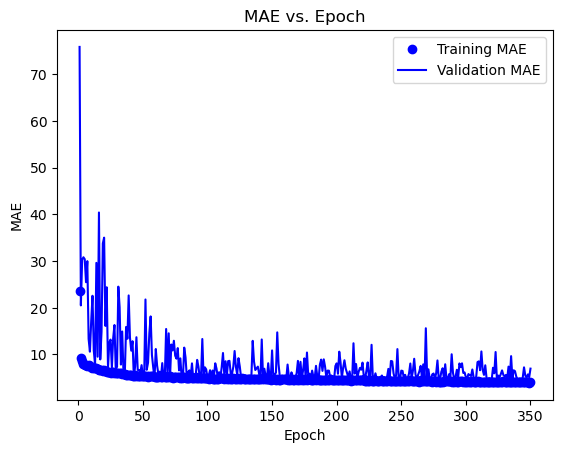

22/22 [==============================] - 6s 288ms/step
6.967723


In [51]:
directory = '/mnt/md0/tempFolder/Allen/TrainTestData/'
def make_rotatedmodel():
    Xaugmentedrotated_train = np.concatenate((X_train, X_train_rotated), axis = 0)
    y_train_duplicated = np.concatenate((y_train, y_train), axis = 0)
    model = get_model()
    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=['mean_absolute_error'])

    csv_logger = CSVLogger('/mnt/md0/tempFolder/Allen/Models/Rotated_log.csv')

    checkpoint = ModelCheckpoint('/mnt/md0/tempFolder/Allen/Models/RotatedModel.h5', monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')
    history = model.fit(Xaugmentedrotated_train, y_train_duplicated, epochs=350, callbacks=[checkpoint, csv_logger], batch_size=14, validation_data=(X_test, y_test), verbose=1)

    # Get MAE values from training history
    train_mae = history.history['mean_absolute_error']
    val_mae = history.history['val_mean_absolute_error']
    epochs = range(1, len(train_mae) + 1)

    plt.figure()
    plt.plot(epochs, train_mae, 'bo', label='Training MAE')
    plt.plot(epochs, val_mae, 'b', label='Validation MAE')
    plt.title('MAE vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

    predictions = model.predict(X_test)

    mae = mean_absolute_error(y_test, predictions)
    print(mae)

    return history

model = make_rotatedmodel()

Epoch 1/350
401/401 [==============================] - ETA: 0s - loss: 24.2563 - mean_absolute_error: 24.2563
Epoch 1: val_mean_absolute_error improved from inf to 26.19229, saving model to /mnt/md0/tempFolder/Allen/Models/TranslatedModel.h5
401/401 [==============================] - 209s 518ms/step - loss: 24.2563 - mean_absolute_error: 24.2563 - val_loss: 26.1923 - val_mean_absolute_error: 26.1923
Epoch 2/350


/mnt/md0/softwares/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


401/401 [==============================] - ETA: 0s - loss: 8.9035 - mean_absolute_error: 8.9035
Epoch 2: val_mean_absolute_error improved from 26.19229 to 11.57196, saving model to /mnt/md0/tempFolder/Allen/Models/TranslatedModel.h5
401/401 [==============================] - 204s 508ms/step - loss: 8.9035 - mean_absolute_error: 8.9035 - val_loss: 11.5720 - val_mean_absolute_error: 11.5720
Epoch 3/350
401/401 [==============================] - ETA: 0s - loss: 8.3061 - mean_absolute_error: 8.3061
Epoch 3: val_mean_absolute_error did not improve from 11.57196
401/401 [==============================] - 198s 493ms/step - loss: 8.3061 - mean_absolute_error: 8.3061 - val_loss: 14.8643 - val_mean_absolute_error: 14.8643
Epoch 4/350
401/401 [==============================] - ETA: 0s - loss: 8.1163 - mean_absolute_error: 8.1163
Epoch 4: val_mean_absolute_error did not improve from 11.57196
401/401 [==============================] - 198s 493ms/step - loss: 8.1163 - mean_absolute_error: 8.1163 - v

Epoch 50/350
401/401 [==============================] - ETA: 0s - loss: 5.5697 - mean_absolute_error: 5.5697
Epoch 50: val_mean_absolute_error did not improve from 5.04058
401/401 [==============================] - 196s 490ms/step - loss: 5.5697 - mean_absolute_error: 5.5697 - val_loss: 10.0600 - val_mean_absolute_error: 10.0600
Epoch 51/350
401/401 [==============================] - ETA: 0s - loss: 5.5521 - mean_absolute_error: 5.5521
Epoch 51: val_mean_absolute_error did not improve from 5.04058
401/401 [==============================] - 197s 491ms/step - loss: 5.5521 - mean_absolute_error: 5.5521 - val_loss: 8.1785 - val_mean_absolute_error: 8.1785
Epoch 52/350
401/401 [==============================] - ETA: 0s - loss: 5.5725 - mean_absolute_error: 5.5725
Epoch 52: val_mean_absolute_error did not improve from 5.04058
401/401 [==============================] - 198s 493ms/step - loss: 5.5725 - mean_absolute_error: 5.5725 - val_loss: 9.1865 - val_mean_absolute_error: 9.1865
Epoch 53/35

Epoch 75/350
401/401 [==============================] - ETA: 0s - loss: 5.3072 - mean_absolute_error: 5.3072
Epoch 75: val_mean_absolute_error did not improve from 5.02244
401/401 [==============================] - 198s 494ms/step - loss: 5.3072 - mean_absolute_error: 5.3072 - val_loss: 14.6124 - val_mean_absolute_error: 14.6124
Epoch 76/350
401/401 [==============================] - ETA: 0s - loss: 5.2640 - mean_absolute_error: 5.2640
Epoch 76: val_mean_absolute_error did not improve from 5.02244
401/401 [==============================] - 200s 498ms/step - loss: 5.2640 - mean_absolute_error: 5.2640 - val_loss: 7.5001 - val_mean_absolute_error: 7.5001
Epoch 77/350
401/401 [==============================] - ETA: 0s - loss: 5.2626 - mean_absolute_error: 5.2626
Epoch 77: val_mean_absolute_error did not improve from 5.02244
401/401 [==============================] - 199s 496ms/step - loss: 5.2626 - mean_absolute_error: 5.2626 - val_loss: 5.9777 - val_mean_absolute_error: 5.9777
Epoch 78/35

401/401 [==============================] - 199s 496ms/step - loss: 4.9963 - mean_absolute_error: 4.9963 - val_loss: 5.9167 - val_mean_absolute_error: 5.9167
Epoch 100/350
401/401 [==============================] - ETA: 0s - loss: 4.9617 - mean_absolute_error: 4.9617
Epoch 100: val_mean_absolute_error did not improve from 4.83809
401/401 [==============================] - 200s 498ms/step - loss: 4.9617 - mean_absolute_error: 4.9617 - val_loss: 10.4494 - val_mean_absolute_error: 10.4494
Epoch 101/350
401/401 [==============================] - ETA: 0s - loss: 4.9762 - mean_absolute_error: 4.9762
Epoch 101: val_mean_absolute_error did not improve from 4.83809
401/401 [==============================] - 200s 498ms/step - loss: 4.9762 - mean_absolute_error: 4.9762 - val_loss: 5.3235 - val_mean_absolute_error: 5.3235
Epoch 102/350
401/401 [==============================] - ETA: 0s - loss: 4.9722 - mean_absolute_error: 4.9722
Epoch 102: val_mean_absolute_error did not improve from 4.83809
401/4

Epoch 149/350
401/401 [==============================] - ETA: 0s - loss: 4.7922 - mean_absolute_error: 4.7922
Epoch 149: val_mean_absolute_error did not improve from 4.83809
401/401 [==============================] - 211s 525ms/step - loss: 4.7922 - mean_absolute_error: 4.7922 - val_loss: 4.8568 - val_mean_absolute_error: 4.8568
Epoch 150/350
401/401 [==============================] - ETA: 0s - loss: 4.7174 - mean_absolute_error: 4.7174
Epoch 150: val_mean_absolute_error did not improve from 4.83809
401/401 [==============================] - 210s 524ms/step - loss: 4.7174 - mean_absolute_error: 4.7174 - val_loss: 6.0889 - val_mean_absolute_error: 6.0889
Epoch 151/350
401/401 [==============================] - ETA: 0s - loss: 4.8318 - mean_absolute_error: 4.8318
Epoch 151: val_mean_absolute_error did not improve from 4.83809
401/401 [==============================] - 210s 525ms/step - loss: 4.8318 - mean_absolute_error: 4.8318 - val_loss: 5.2629 - val_mean_absolute_error: 5.2629
Epoch 1

401/401 [==============================] - 211s 525ms/step - loss: 4.6530 - mean_absolute_error: 4.6530 - val_loss: 9.7752 - val_mean_absolute_error: 9.7752
Epoch 174/350
401/401 [==============================] - ETA: 0s - loss: 4.5533 - mean_absolute_error: 4.5533
Epoch 174: val_mean_absolute_error did not improve from 4.81133
401/401 [==============================] - 210s 525ms/step - loss: 4.5533 - mean_absolute_error: 4.5533 - val_loss: 7.6470 - val_mean_absolute_error: 7.6470
Epoch 175/350
401/401 [==============================] - ETA: 0s - loss: 4.5931 - mean_absolute_error: 4.5931
Epoch 175: val_mean_absolute_error did not improve from 4.81133
401/401 [==============================] - 210s 524ms/step - loss: 4.5931 - mean_absolute_error: 4.5931 - val_loss: 5.7998 - val_mean_absolute_error: 5.7998
Epoch 176/350
401/401 [==============================] - ETA: 0s - loss: 4.7254 - mean_absolute_error: 4.7254
Epoch 176: val_mean_absolute_error did not improve from 4.81133
401/401

401/401 [==============================] - ETA: 0s - loss: 4.6653 - mean_absolute_error: 4.6653
Epoch 198: val_mean_absolute_error did not improve from 4.68595
401/401 [==============================] - 210s 524ms/step - loss: 4.6653 - mean_absolute_error: 4.6653 - val_loss: 4.8316 - val_mean_absolute_error: 4.8316
Epoch 199/350
401/401 [==============================] - ETA: 0s - loss: 4.6368 - mean_absolute_error: 4.6368
Epoch 199: val_mean_absolute_error did not improve from 4.68595
401/401 [==============================] - 210s 524ms/step - loss: 4.6368 - mean_absolute_error: 4.6368 - val_loss: 5.4700 - val_mean_absolute_error: 5.4700
Epoch 200/350
401/401 [==============================] - ETA: 0s - loss: 4.5856 - mean_absolute_error: 4.5856
Epoch 200: val_mean_absolute_error did not improve from 4.68595
401/401 [==============================] - 210s 525ms/step - loss: 4.5856 - mean_absolute_error: 4.5856 - val_loss: 5.5739 - val_mean_absolute_error: 5.5739
Epoch 201/350
401/401

Epoch 223/350
401/401 [==============================] - ETA: 0s - loss: 4.5335 - mean_absolute_error: 4.5335
Epoch 223: val_mean_absolute_error did not improve from 4.67969
401/401 [==============================] - 210s 525ms/step - loss: 4.5335 - mean_absolute_error: 4.5335 - val_loss: 8.1913 - val_mean_absolute_error: 8.1913
Epoch 224/350
401/401 [==============================] - ETA: 0s - loss: 4.5571 - mean_absolute_error: 4.5571
Epoch 224: val_mean_absolute_error did not improve from 4.67969
401/401 [==============================] - 210s 524ms/step - loss: 4.5571 - mean_absolute_error: 4.5571 - val_loss: 5.6324 - val_mean_absolute_error: 5.6324
Epoch 225/350
401/401 [==============================] - ETA: 0s - loss: 4.5735 - mean_absolute_error: 4.5735
Epoch 225: val_mean_absolute_error did not improve from 4.67969
401/401 [==============================] - 210s 524ms/step - loss: 4.5735 - mean_absolute_error: 4.5735 - val_loss: 5.0428 - val_mean_absolute_error: 5.0428
Epoch 2

Epoch 248/350
401/401 [==============================] - ETA: 0s - loss: 4.5288 - mean_absolute_error: 4.5288
Epoch 248: val_mean_absolute_error did not improve from 4.67969
401/401 [==============================] - 209s 521ms/step - loss: 4.5288 - mean_absolute_error: 4.5288 - val_loss: 4.7607 - val_mean_absolute_error: 4.7607
Epoch 249/350
401/401 [==============================] - ETA: 0s - loss: 4.4177 - mean_absolute_error: 4.4177
Epoch 249: val_mean_absolute_error did not improve from 4.67969
401/401 [==============================] - 210s 523ms/step - loss: 4.4177 - mean_absolute_error: 4.4177 - val_loss: 11.3097 - val_mean_absolute_error: 11.3097
Epoch 250/350
401/401 [==============================] - ETA: 0s - loss: 4.4817 - mean_absolute_error: 4.4817
Epoch 250: val_mean_absolute_error did not improve from 4.67969
401/401 [==============================] - 210s 523ms/step - loss: 4.4817 - mean_absolute_error: 4.4817 - val_loss: 5.2206 - val_mean_absolute_error: 5.2206
Epoch

Epoch 273/350
401/401 [==============================] - ETA: 0s - loss: 4.2908 - mean_absolute_error: 4.2908
Epoch 273: val_mean_absolute_error did not improve from 4.67969
401/401 [==============================] - 210s 523ms/step - loss: 4.2908 - mean_absolute_error: 4.2908 - val_loss: 5.5819 - val_mean_absolute_error: 5.5819
Epoch 274/350
401/401 [==============================] - ETA: 0s - loss: 4.2962 - mean_absolute_error: 4.2962
Epoch 274: val_mean_absolute_error did not improve from 4.67969
401/401 [==============================] - 210s 525ms/step - loss: 4.2962 - mean_absolute_error: 4.2962 - val_loss: 4.8164 - val_mean_absolute_error: 4.8164
Epoch 275/350
401/401 [==============================] - ETA: 0s - loss: 4.3738 - mean_absolute_error: 4.3738
Epoch 275: val_mean_absolute_error did not improve from 4.67969
401/401 [==============================] - 210s 523ms/step - loss: 4.3738 - mean_absolute_error: 4.3738 - val_loss: 6.4952 - val_mean_absolute_error: 6.4952
Epoch 2

Epoch 322/350
401/401 [==============================] - ETA: 0s - loss: 4.2957 - mean_absolute_error: 4.2957
Epoch 322: val_mean_absolute_error did not improve from 4.51360
401/401 [==============================] - 210s 523ms/step - loss: 4.2957 - mean_absolute_error: 4.2957 - val_loss: 5.0372 - val_mean_absolute_error: 5.0372
Epoch 323/350
401/401 [==============================] - ETA: 0s - loss: 4.2430 - mean_absolute_error: 4.2430
Epoch 323: val_mean_absolute_error did not improve from 4.51360
401/401 [==============================] - 210s 524ms/step - loss: 4.2430 - mean_absolute_error: 4.2430 - val_loss: 4.6796 - val_mean_absolute_error: 4.6796
Epoch 324/350
401/401 [==============================] - ETA: 0s - loss: 4.1294 - mean_absolute_error: 4.1294
Epoch 324: val_mean_absolute_error did not improve from 4.51360
401/401 [==============================] - 210s 523ms/step - loss: 4.1294 - mean_absolute_error: 4.1294 - val_loss: 4.9080 - val_mean_absolute_error: 4.9080
Epoch 3

Epoch 347/350
401/401 [==============================] - ETA: 0s - loss: 4.1208 - mean_absolute_error: 4.1208
Epoch 347: val_mean_absolute_error did not improve from 4.51360
401/401 [==============================] - 216s 538ms/step - loss: 4.1208 - mean_absolute_error: 4.1208 - val_loss: 6.1340 - val_mean_absolute_error: 6.1340
Epoch 348/350
401/401 [==============================] - ETA: 0s - loss: 4.0440 - mean_absolute_error: 4.0440
Epoch 348: val_mean_absolute_error did not improve from 4.51360
401/401 [==============================] - 216s 539ms/step - loss: 4.0440 - mean_absolute_error: 4.0440 - val_loss: 5.6330 - val_mean_absolute_error: 5.6330
Epoch 349/350
401/401 [==============================] - ETA: 0s - loss: 4.1031 - mean_absolute_error: 4.1031
Epoch 349: val_mean_absolute_error did not improve from 4.51360
401/401 [==============================] - 217s 540ms/step - loss: 4.1031 - mean_absolute_error: 4.1031 - val_loss: 4.6271 - val_mean_absolute_error: 4.6271
Epoch 3

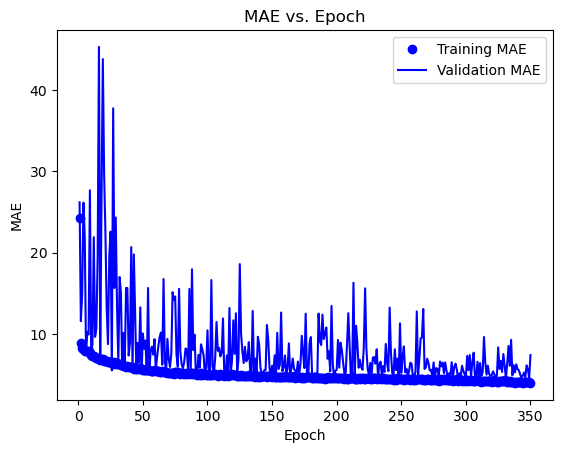

22/22 [==============================] - 7s 295ms/step
7.3940434


In [54]:
directory = '/mnt/md0/tempFolder/Allen/TrainTestData/'
def make_translatedmodel():
    Xaugmentedtranslated_train = np.concatenate((X_train, X_train_shifted), axis = 0)
    y_train_duplicated = np.concatenate((y_train, y_train), axis = 0)
    model = get_model()
    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=['mean_absolute_error'])

    csv_logger = CSVLogger('/mnt/md0/tempFolder/Allen/Models/Translated_log.csv')

    checkpoint = ModelCheckpoint('/mnt/md0/tempFolder/Allen/Models/TranslatedModel.h5', monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')
    history = model.fit(Xaugmentedtranslated_train, y_train_duplicated, epochs=350, callbacks=[checkpoint, csv_logger], batch_size=14, validation_data=(X_test, y_test), verbose=1)

    # Get MAE values from training history
    train_mae = history.history['mean_absolute_error']
    val_mae = history.history['val_mean_absolute_error']
    epochs = range(1, len(train_mae) + 1)

    plt.figure()
    plt.plot(epochs, train_mae, 'bo', label='Training MAE')
    plt.plot(epochs, val_mae, 'b', label='Validation MAE')
    plt.title('MAE vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

    predictions = model.predict(X_test)

    mae = mean_absolute_error(y_test, predictions)
    print(mae)

    return history

model = make_translatedmodel()

In [21]:
#@title Saliency Map generation function with binary mask
def Normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))
def saliencyBinaryMap(model, X):
    saliencyMaps = []
    for idx, i in enumerate(X):
        img = i.reshape((1, *X[0].shape))
        img = img.reshape((*img.shape, 1))
        #print(np.shape(i), *X[0].shape, np.shape(img))
        img = tf.Variable(img, dtype=float)
        with tf.GradientTape() as tape:
            pred  = model(img, training=False)
            #print('prediction: ', pred)
            classSorted = np.argsort(pred.numpy().flatten())[::-1]
            #print('classSorted: ', classSorted)
            loss = pred[0][classSorted[0]]
            #print('loss: ', loss)
        grad = tape.gradient(loss, img)
        gradAbs = tf.math.abs(grad)
        gradMax = np.max(gradAbs, axis=4)[0]
        #print('grad shape: ', np.shape(grad))
# create binary mask using i, with 1 inside the brain and 0 outside
        binaryMask = np.where(i > 0, 1, 0)
        gradMax = gradMax * binaryMask
# only keep voxels in gradMax that are 1 in the binary mask
        saliencyMaps.append(Normalize(gradMax))
    return np.asarray(saliencyMaps)

In [4]:
# camcandir = '/mnt/md0/tempFolder/Allen/VolscamcanCAmonthNativeSpace.npy'
# camimages = np.load(camcandir)
#plt.imshow(camimages[0,:,:,64], cmap='gray')
#print(camimages.shape)

camcandir = '/mnt/md0/tempFolder/Allen/VolscamcanCAmonthAtlasSpace.npy'
camimages = np.load(camcandir)

(651, 128, 128, 128)


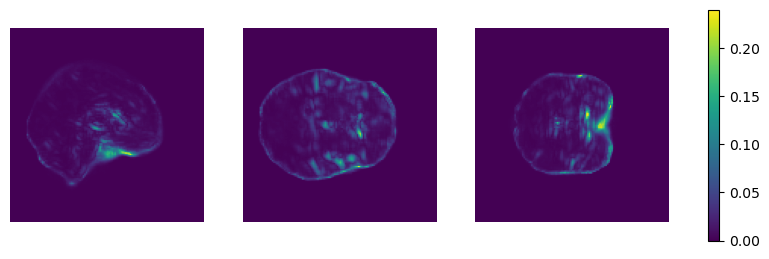

In [26]:
from tensorflow.keras.models import load_model
def NormalSaliencyPicture():
    normmodel = load_model('/mnt/md0/tempFolder/Allen/Models/NormalModel.h5')
    NormalSaliency = saliencyBinaryMap(normmodel, camimages) ##changed to use validation set
    print(NormalSaliency.shape)
    saldir = '/mnt/md0/tempFolder/Allen/AugmentationSaliencies/'
    np.save(saldir + 'NormalSaliencyAtlas.npy', NormalSaliency)
    avgnormsal = np.mean(NormalSaliency, axis = 0)
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    for axes in ax:
        axes.set_aspect('equal')
        axes.axis('off')

    im = ax[0].imshow(avgnormsal[64, :, :], vmin=0)
    #ax[0].set_title('Slice 16 (YZ plane)')
    ax[1].imshow(avgnormsal[:, 64, :], vmin=0)
    #ax[1].set_title('Slice 16 (XZ plane)')
    ax[2].imshow(avgnormsal[:, :, 64], vmin=0)
    #ax[2].set_title('Slice 16 (XY plane)')

    fig.colorbar(im, ax=ax, orientation='vertical', fraction=.1)

#   plt.savefig(f"saldir/normalsaliencyavg.png")

    plt.show()
NormalSaliencyPicture()

(702, 128, 128, 128)


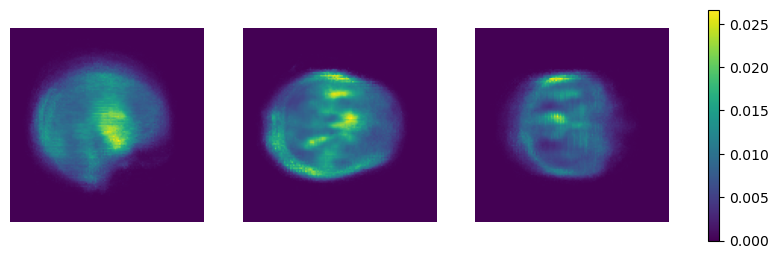

In [24]:
def DoubleSaliencyPicture():
    doublemodel = load_model('/mnt/md0/tempFolder/Allen/Models/DoubleModel.h5')
    DoubleSaliency = saliencyBinaryMap(doublemodel, X_test)
    print(DoubleSaliency.shape)
    saldir = '/mnt/md0/tempFolder/Allen/AugmentationSaliencies/'
    np.save(saldir + 'DoubleSaliencyAtlasvalidationset.npy', DoubleSaliency)
    avgdoublesal = np.mean(DoubleSaliency, axis = 0)
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    for axes in ax:
        axes.set_aspect('equal')
        axes.axis('off')

    im = ax[0].imshow(avgdoublesal[64, :, :], vmin=0)
    #ax[0].set_title('Slice 16 (YZ plane)')
    ax[1].imshow(avgdoublesal[:, 64, :], vmin=0)
    #ax[1].set_title('Slice 16 (XZ plane)')
    ax[2].imshow(avgdoublesal[:, :, 64], vmin=0)
    #ax[2].set_title('Slice 16 (XY plane)')

    fig.colorbar(im, ax=ax, orientation='vertical', fraction=.1)

#     plt.savefig(f"saldir/doublesaliencyavg.png")

    plt.show()
DoubleSaliencyPicture()

(651, 128, 128, 128)


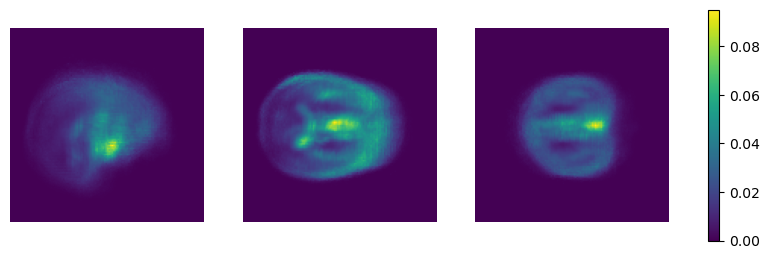

In [78]:
def RotatedSaliencyPicture():
    rotatemodel = load_model('/mnt/md0/tempFolder/Allen/Models/RotatedModel.h5')
    RotateSaliency = saliencyBinaryMap(rotatemodel, camimages)
    print(RotateSaliency.shape)
    saldir = '/mnt/md0/tempFolder/Allen/AugmentationSaliencies/'
    np.save(saldir + 'RotateSaliencyAtlas.npy', RotateSaliency)
    avgrotatesal = np.mean(RotateSaliency, axis = 0)
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    for axes in ax:
        axes.set_aspect('equal')
        axes.axis('off')

    im = ax[0].imshow(avgrotatesal[64, :, :], vmin=0)
    #ax[0].set_title('Slice 16 (YZ plane)')
    ax[1].imshow(avgrotatesal[:, 64, :], vmin=0)
    #ax[1].set_title('Slice 16 (XZ plane)')
    ax[2].imshow(avgrotatesal[:, :, 64], vmin=0)
    #ax[2].set_title('Slice 16 (XY plane)')

    fig.colorbar(im, ax=ax, orientation='vertical', fraction=.1)

    #plt.savefig(f"saldir/rotatesaliencyavg.png")

    plt.show()
RotatedSaliencyPicture()

(651, 128, 128, 128)


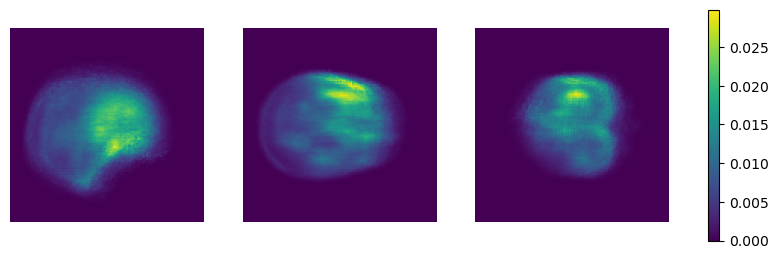

In [79]:
def TranslateSaliencyPicture():
    translatemodel = load_model('/mnt/md0/tempFolder/Allen/Models/TranslatedModel.h5')
    TranslateSaliency = saliencyBinaryMap(translatemodel, camimages)
    print(TranslateSaliency.shape)
    saldir = '/mnt/md0/tempFolder/Allen/AugmentationSaliencies/'
    np.save(saldir + 'TranslateSaliencyAtlas.npy', TranslateSaliency)
    avgtranslatesal = np.mean(TranslateSaliency, axis = 0)
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    for axes in ax:
        axes.set_aspect('equal')
        axes.axis('off')

    im = ax[0].imshow(avgtranslatesal[64, :, :], vmin=0)
    #ax[0].set_title('Slice 16 (YZ plane)')
    ax[1].imshow(avgtranslatesal[:, 64, :], vmin=0)
    #ax[1].set_title('Slice 16 (XZ plane)')
    ax[2].imshow(avgtranslatesal[:, :, 64], vmin=0)
    #ax[2].set_title('Slice 16 (XY plane)')

    fig.colorbar(im, ax=ax, orientation='vertical', fraction=.1)

    #plt.savefig(f"saldir/translatesaliencyavg.png")

    plt.show()
TranslateSaliencyPicture()

(651, 128, 128, 128)


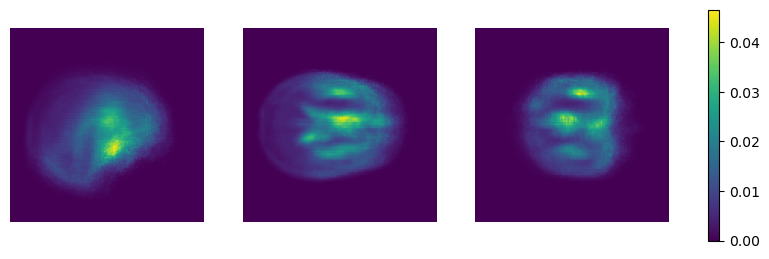

In [80]:
def ScaleSaliencyPicture():
    scalemodel = load_model('/mnt/md0/tempFolder/Allen/Models/ScaledModel.h5')
    ScaledSaliency = saliencyBinaryMap(scalemodel, camimages)
    print(ScaledSaliency.shape)
    saldir = '/mnt/md0/tempFolder/Allen/AugmentationSaliencies/'
    np.save(saldir + 'ScaledSaliencyAtlas.npy', ScaledSaliency)
    avgscalesal = np.mean(ScaledSaliency, axis = 0)
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    for axes in ax:
        axes.set_aspect('equal')
        axes.axis('off')

    im = ax[0].imshow(avgscalesal[64, :, :], vmin=0)
    #ax[0].set_title('Slice 16 (YZ plane)')
    ax[1].imshow(avgscalesal[:, 64, :], vmin=0)
    #ax[1].set_title('Slice 16 (XZ plane)')
    ax[2].imshow(avgscalesal[:, :, 64], vmin=0)
    #ax[2].set_title('Slice 16 (XY plane)')

    fig.colorbar(im, ax=ax, orientation='vertical', fraction=.1)

    #plt.savefig(f"saldir/scalesaliencyavg.png")

    plt.show()
ScaleSaliencyPicture()

(651, 128, 128, 128)


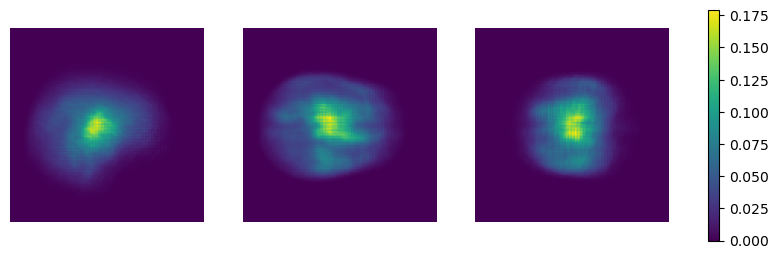

In [82]:
def BlurSaliencyPicture():
    blurmodel = load_model('/mnt/md0/tempFolder/Allen/Models/BlurredModel.h5')
    BlurredSaliency = saliencyBinaryMap(blurmodel, camimages)
    print(BlurredSaliency.shape)
    saldir = '/mnt/md0/tempFolder/Allen/AugmentationSaliencies/'
    np.save(saldir + 'BlurredSaliencyAtlas.npy', BlurredSaliency)
    avgblursal = np.mean(BlurredSaliency, axis = 0)
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    for axes in ax:
        axes.set_aspect('equal')
        axes.axis('off')

    im = ax[0].imshow(avgblursal[64, :, :], vmin=0)
    #ax[0].set_title('Slice 16 (YZ plane)')
    ax[1].imshow(avgblursal[:, 64, :], vmin=0)
    #ax[1].set_title('Slice 16 (XZ plane)')
    ax[2].imshow(avgblursal[:, :, 64], vmin=0)
    #ax[2].set_title('Slice 16 (XY plane)')

    fig.colorbar(im, ax=ax, orientation='vertical', fraction=.1)

    #plt.savefig(f"saldir/scalesaliencyavg.png")

    plt.show()
BlurSaliencyPicture()

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable

dir = '/mnt/md0/tempFolder/Allen/AugmentationSaliencies/'

models = ['NormalSaliencyAtlas','DoubleSaliencyAtlas', 'BlurredSaliencyAtlas', 'RotateSaliencyAtlas', 'TranslateSaliencyAtlas', 'ScaledSaliencyAtlas']
# Initialize min and max with extreme values
global_min = np.inf
global_max = -np.inf

# First loop through each file to find the global min and max
for model in models:
    # Load the numpy array file for this model
    Saliency = np.load(os.path.join(dir, f'{model}.npy'))
    
    # Calculate the mean of the array across the 0th axis
    avgsal = np.mean(Saliency, axis = 0)

    # Update global min and max
    global_min = min(global_min, avgsal.min())
    global_max = max(global_max, avgsal.max())
print('globalmax')
print(global_max)
# Create a figure with a subplot for each model's x, y, z axis
fig, axs = plt.subplots(len(models), 3, figsize=(10, 3*len(models)))

for i, model in enumerate(models):
    # Load the numpy array file for this model
    Saliency = np.load(os.path.join(dir, f'{model}.npy'))
    
    # Calculate the mean of the array across the 0th axis
    avgsal = np.mean(Saliency, axis = 0)

    # Plot the 64th slice along each axis with global color scale
    im = axs[i, 0].imshow(avgsal[64, :, :], vmin=global_min, vmax=0.3)
    axs[i, 1].imshow(avgsal[:, 64, :], vmin=global_min, vmax=0.3)
    axs[i, 2].imshow(avgsal[:, :, 64], vmin=global_min, vmax=0.3)

    # Set aspect ratio and turn off axis for each subplot
    for j in range(3):
        axs[i, j].set_aspect('equal')
        axs[i, j].axis('off')

    # Add a colorbar to the right of each row
    divider = make_axes_locatable(axs[i, 2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

# Save the figure
plt.savefig(os.path.join(dir, 'AllSalienciesAtlasSmallerVMAX.png'))

# Close the figure to free up memory
plt.close(fig)


globalmax
0.9021942684524015


In [6]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from skimage.metrics import hausdorff_distance
from skimage.metrics import normalized_mutual_information
from statistics import mean
from scipy import stats


def adjustIntensity(saliencyMap, rawImage):
    # returns images with intensity normalized between 0 and 1
    mnraw = np.min(np.min(np.min(rawImage, axis=0),axis=0),axis=0)
    mxraw = np.max(np.max(np.max(rawImage, axis=0),axis=0),axis=0)
    
    mnsal = np.min(np.min(np.min(saliencyMap, axis=0),axis=0),axis=0)
    mxsal = np.max(np.max(np.max(saliencyMap, axis=0),axis=0),axis=0)
    
    sal2 = (saliencyMap - mnsal)/(mxsal - mnsal)
    raw2 = (rawImage - mnraw)/(mxraw - mnraw)
    
    sal2 = np.where(sal2 > 0.2, 1, 0)
    raw2 = np.where(raw2 > 0.2, 1, 0)
    
    return sal2, raw2

def confidence_interval(data, confidence=0.95):
    # Calculate the mean and the standard error
    mean = np.mean(data)
    sem = stats.sem(data)
    # Calculate the confidence interval
    ci = sem * stats.t.ppf((1 + confidence) / 2., len(data)-1)
    return mean, mean-ci, mean+ci

def structSim3D(saliencyMap, rawImage):
    # returns mean structural similarity index
    sMap, rImage = adjustIntensity(saliencyMap, rawImage)
    dataRange = 1 - 0 # change if intensity is not adjusted
    ssi = ssim(sMap, rImage, data_range=dataRange)
    return ssi

def mse(saliencyMap, rawImage):
    # returns mean squared error
    saliencyMap, rawImage = adjustIntensity(saliencyMap, rawImage)
    return mean_squared_error(saliencyMap, rawImage)

# def hd(saliencyMap, rawImage):
#     # returns Hausdorff distance between coordinates of non-0 voxels
#     # change method to modified if needed
#     saliencyMap, rawImage = adjustIntensity(saliencyMap, rawImage)
#     return hausdorff_distance(saliencyMap, rawImage)

def nmi(saliencyMap, rawImage):
    # returns normalized mutual information. 
    # Higher NMI implies more similar input images.
    saliencyMap, rawImage = adjustIntensity(saliencyMap, rawImage)
    return normalized_mutual_information(saliencyMap, rawImage)

def dice_coefficient(saliencyMap, rawImage):
    saliencyMap, rawImage = adjustIntensity(saliencyMap, rawImage)
    return np.sum(saliencyMap[rawImage==1])*2.0 / (np.sum(saliencyMap) + np.sum(rawImage))

functions = [structSim3D, mse, nmi, dice_coefficient]

dir = '/mnt/md0/tempFolder/Allen/AugmentationSaliencies/'
models = ['NormalSaliencyAtlas','DoubleSaliencyAtlas', 'BlurredSaliencyAtlas', 'RotateSaliencyAtlas', 'TranslateSaliencyAtlas', 'ScaledSaliencyAtlas']

# Initialize an empty dictionary to store the results of each function
function_results = {f: [] for f in functions}
normal_model_results = {}

for model in models:
    Saliency = np.load(os.path.join(dir, f'{model}.npy'))
    for i in range (651):
        saliencyFile = Saliency[i]
        brainMGZFile = camimages[i]
        for f in functions:
            result = f(saliencyFile, brainMGZFile)
            function_results[f].append(result)
    # After processing each model, calculate the mean and std of the results
    for f in functions:
        mean_result = np.mean(function_results[f])
        std_result = np.std(function_results[f])
        # If processing the 'NormalSaliencyAtlas' model, store the mean and std
        if model == 'NormalSaliencyAtlas':
            normal_model_results[f] = (mean_result, std_result)
            print(mean_result, std_result)
        else:
            # For other models, normalize the mean and std by the 'NormalSaliencyAtlas' results
            normalized_mean = mean_result / normal_model_results[f][0]
            normalized_std = std_result / normal_model_results[f][1]
            print(f'Result for {f.__name__} in {model}: {normalized_mean} ± {normalized_std}')
        function_results[f].clear()  # Clear the list for the next model

        
##Calculate confidence intervals, add dice coefficient

            




0.8157815447458622 0.0037583080676509483
0.10846361989432948 0.0026211216038238947
1.0001027113524703 9.111649303120015e-05
0.0019181435886267118 0.0010633826331310893
Result for structSim3D in DoubleSaliencyAtlas: 0.9982199261423773 ± 0.9933604273597664
Result for mse in DoubleSaliencyAtlas: 1.000833565652206 ± 0.9793303323404388
Result for nmi in DoubleSaliencyAtlas: 1.000006039832728 ± 1.1489630601808858
Result for dice_coefficient in DoubleSaliencyAtlas: 1.1145108564477353 ± 0.9893335204074627
Result for structSim3D in BlurredSaliencyAtlas: 0.9992605254233482 ± 1.0005197408940016
Result for mse in BlurredSaliencyAtlas: 0.9726975542964693 ± 0.9759021283407733
Result for nmi in BlurredSaliencyAtlas: 1.0160879290627083 ± 51.48564619913546
Result for dice_coefficient in BlurredSaliencyAtlas: 30.131125253433883 ± 15.467171833467184
Result for structSim3D in RotateSaliencyAtlas: 0.9985435442482903 ± 1.0277008748226266
Result for mse in RotateSaliencyAtlas: 0.9994445214226049 ± 0.97894867

In [11]:
print(camimages.shape)
print(camimages[1].shape)

camcanage = np.load('/mnt/md0/tempFolder/Allen/CAcamcanCAmonthAtlasSpace.npy')
# camcanid = np.load('/mnt/md0/tempFolder/Allen/IDscamcanCAmonthNativeSpace.npy')
# for age in camcanage:
#     print(age)
# for ids in camcanid:
#     print(ids)
# print(np.max(camcanage))
# print(np.min(camcanage))

(651, 128, 128, 128)
(128, 128, 128)


In [17]:
X_test = np.load('/mnt/md0/tempFolder/Allen/TrainTestData/Xtest.npy')
y_test = np.load('/mnt/md0/tempFolder/Allen/TrainTestData/ytest.npy')

#@title Testing Dataset Accuracy
normalModel = tf.keras.models.load_model('/mnt/md0/tempFolder/Allen/Models/NormalModel.h5')
normalpredictions = normalModel.predict(camimages)
normalmae = mean_absolute_error(camcanage, normalpredictions)
print("Normal Model Test MAE: ", normalmae,  "\n")

blurredModel = tf.keras.models.load_model('/mnt/md0/tempFolder/Allen/Models/BlurredModel.h5')
blurredpredictions = blurredModel.predict(camimages)
blurredmae = mean_absolute_error(camcanage, blurredpredictions)
print("Blurred Model Test MAE: ", blurredmae,  "\n")


rotatedModel = tf.keras.models.load_model('/mnt/md0/tempFolder/Allen/Models/RotatedModel.h5')
rotatedpredictions = rotatedModel.predict(camimages)
rotatedmae = mean_absolute_error(camcanage, rotatedpredictions)
print("Rotated Model Test MAE: ", rotatedmae,  "\n")


translatedModel = tf.keras.models.load_model('/mnt/md0/tempFolder/Allen/Models/TranslatedModel.h5')
translatedpredictions = translatedModel.predict(camimages)
translatedmae = mean_absolute_error(camcanage, translatedpredictions)
print("Translated Model Test MAE: ", translatedmae,  "\n")

scaledModel = tf.keras.models.load_model('/mnt/md0/tempFolder/Allen/Models/ScaledModel.h5')
scaledpredictions = scaledModel.predict(camimages)
scaledmae = mean_absolute_error(camcanage, scaledpredictions)
print("Scaled Model Test MAE: ", scaledmae,  "\n")

doubleModel = tf.keras.models.load_model('/mnt/md0/tempFolder/Allen/Models/DoubleModel.h5')
doublepredictions = doubleModel.predict(camimages)
doublemae = mean_absolute_error(camcanage, doublepredictions)
print("Double Model Test MAE: ", doublemae,  "\n")

print("Validation MAE")

#@title Testing Dataset Accuracy
normalModel = tf.keras.models.load_model('/mnt/md0/tempFolder/Allen/Models/NormalModel.h5')
normalpredictions = normalModel.predict(X_test)
normalmae = mean_absolute_error(y_test, normalpredictions)
print("Normal Model Test MAE: ", normalmae,  "\n")

blurredModel = tf.keras.models.load_model('/mnt/md0/tempFolder/Allen/Models/BlurredModel.h5')
blurredpredictions = blurredModel.predict(X_test)
blurredmae = mean_absolute_error(y_test, blurredpredictions)
print("Blurred Model Test MAE: ", blurredmae,  "\n")


rotatedModel = tf.keras.models.load_model('/mnt/md0/tempFolder/Allen/Models/RotatedModel.h5')
rotatedpredictions = rotatedModel.predict(X_test)
rotatedmae = mean_absolute_error(y_test, rotatedpredictions)
print("Rotated Model Test MAE: ", rotatedmae,  "\n")


translatedModel = tf.keras.models.load_model('/mnt/md0/tempFolder/Allen/Models/TranslatedModel.h5')
translatedpredictions = translatedModel.predict(X_test)
translatedmae = mean_absolute_error(y_test, translatedpredictions)
print("Translated Model Test MAE: ", translatedmae,  "\n")

scaledModel = tf.keras.models.load_model('/mnt/md0/tempFolder/Allen/Models/ScaledModel.h5')
scaledpredictions = scaledModel.predict(X_test)
scaledmae = mean_absolute_error(y_test, scaledpredictions)
print("Scaled Model Test MAE: ", scaledmae,  "\n")

doubleModel = tf.keras.models.load_model('/mnt/md0/tempFolder/Allen/Models/DoubleModel.h5')
doublepredictions = doubleModel.predict(X_test)
doublemae = mean_absolute_error(y_test, doublepredictions)
print("Double Model Test MAE: ", doublemae,  "\n")


21/21 [==============================] - 2s 77ms/step
Normal Model Test MAE:  13.566861143097533 

21/21 [==============================] - 2s 77ms/step
Blurred Model Test MAE:  14.075947851600002 

21/21 [==============================] - 2s 85ms/step
Rotated Model Test MAE:  13.006842359551637 

21/21 [==============================] - 2s 77ms/step
Translated Model Test MAE:  11.367467243997366 

21/21 [==============================] - 2s 77ms/step
Scaled Model Test MAE:  12.943476991433702 

21/21 [==============================] - 2s 77ms/step
Double Model Test MAE:  13.433980832195136 

Validation MAE
22/22 [==============================] - 8s 362ms/step
Normal Model Test MAE:  4.89762 

22/22 [==============================] - 2s 73ms/step
Blurred Model Test MAE:  4.7428985 

22/22 [==============================] - 2s 71ms/step
Rotated Model Test MAE:  4.61566 

22/22 [==============================] - 2s 75ms/step
Translated Model Test MAE:  4.5134816 

22/22 [===============

In [ ]:
rotatedModel = tf.keras.models.load_model('/mnt/md0/tempFolder/Allen/Models/RotatedModel.h5')
rotatedpredictions = rotatedModel.predict(X_train)
# print(rotatedpredictions.shape)
# print(camcanage.shape)
rotatedpredictions = np.squeeze(rotatedpredictions)
rotatedmae = abs(camcanage - rotatedpredictions)
c,b = np.histogram(rotatedmae)
plt.stairs(c, b)
rotatedmae = mean_absolute_error(X_test, rotatedpredictions)
print("Rotated Model Test MAE: ", rotatedmae,  "\n")

In [31]:
print(camimages.shape)
print(camcanage.shape)

(651, 128, 128, 128)
(651,)


In [8]:
print(camcanage.shape)
shuffled = np.copy(camcanage)
np.random.shuffle(shuffled)
# normalModel = tf.keras.models.load_model('/mnt/md0/tempFolder/Allen/Models/NormalModel.h5')
normalpredictions = normalModel.predict(camimages)
normalmae = mean_absolute_error(shuffled, normalpredictions)
print("Normal Model Test MAE: ", normalmae,  "\n")

blurredModel = tf.keras.models.load_model('/mnt/md0/tempFolder/Allen/Models/BlurredModel.h5')
blurredpredictions = blurredModel.predict(camimages)
blurredmae = mean_absolute_error(shuffled, blurredpredictions)
print("Blurred Model Test MAE: ", blurredmae,  "\n")


rotatedModel = tf.keras.models.load_model('/mnt/md0/tempFolder/Allen/Models/RotatedModel.h5')
rotatedpredictions = rotatedModel.predict(camimages)
rotatedmae = mean_absolute_error(shuffled, rotatedpredictions)
print("Rotated Model Test MAE: ", rotatedmae,  "\n")


translatedModel = tf.keras.models.load_model('/mnt/md0/tempFolder/Allen/Models/TranslatedModel.h5')
translatedpredictions = translatedModel.predict(camimages)
translatedmae = mean_absolute_error(shuffled, translatedpredictions)
print("Translated Model Test MAE: ", translatedmae,  "\n")

scaledModel = tf.keras.models.load_model('/mnt/md0/tempFolder/Allen/Models/ScaledModel.h5')
scaledpredictions = scaledModel.predict(camimages)
scaledmae = mean_absolute_error(shuffled, scaledpredictions)
print("Scaled Model Test MAE: ", scaledmae,  "\n")

doubleModel = tf.keras.models.load_model('/mnt/md0/tempFolder/Allen/Models/DoubleModel.h5')
doublepredictions = doubleModel.predict(camimages)
doublemae = mean_absolute_error(shuffled, doublepredictions)
print("Double Model Test MAE: ", doublemae,  "\n")

(651,)
21/21 [==============================] - 2s 76ms/step
Normal Model Test MAE:  16.41850067162111 

21/21 [==============================] - 2s 77ms/step
Blurred Model Test MAE:  16.234031589584234 

21/21 [==============================] - 2s 77ms/step
Rotated Model Test MAE:  16.457825854370306 

21/21 [==============================] - 2s 77ms/step
Translated Model Test MAE:  16.62534149310556 

21/21 [==============================] - 2s 77ms/step
Scaled Model Test MAE:  16.41499456262076 

21/21 [==============================] - 2s 77ms/step
Double Model Test MAE:  16.356211788570093 

